In [1]:
# !pip install polars
# !pip install lightgbm
# !pip install xgboost
# !pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 27.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 8.2 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 4.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import time
import numpy as np
import polars as pl
import pandas as pd
import os
import re 
import sklearn 
from scipy import stats  
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2, f_classif 
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import xgboost as xgb
import statsmodels.api as sm
from sklearn.ensemble import VotingClassifier
# Настраиваем тему и палитру для Seaborn
sns.set_theme('notebook')
sns.set_palette('RdGy')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/test-parquet/test.parquet
/kaggle/input/train-data/train.parquet
/kaggle/input/campaigns/campaigns_meta.parquet
/kaggle/input/campaigns/categories.parquet
/kaggle/input/final-data/df5.parquet
/kaggle/input/dataframe/df4.parquet


# AvitoTech ML cup 2024

**Задача:** Разработать модель, которая сможет рекомендовать пользователю наиболее релевантную рекламу на основе реальных данных после анонимизации. Модель должна предсказывать вероятность того, что пользователь кликнет на рекламное объявление, исходя из его характеристик и предпочтений.

[Ссылка на соревнование](https://ods.ai/competitions/avitotechmlcup2024)

***Признаки и доступные данные для проекта.***

**Данные о взаимодействии Пользователя и рекламной компании (train.parquet и test.parquet)**
-  |-- platform_id: id платформы (Android, Ios и т.п.)
-  |-- user_id: id Пользователя
-  | -- adv_campaign_id: id рекламной компании
-  |-- target: клик / не клик
-  | -- banner_code: код баннера
-  | -- adv_creative_id: индификатор креатива
-  | -- event_date: date Дата показа рекламной кампании пользователю
-  |-- is_main: boolean True - показ рекламы был осуществлен с главной страницы

**Данные о категориях (categories.parquet)**
- |-- microcat_id: id микрокатегории
- |-- level_id: id уровня в дереве микрокатегорий
- |-- parent_microcat_id: id родительской микрокатегории
- |-- logcat_id: id логической категории
- |-- vertical_id: id вертикали
- |-- category_id: id категории 
 

**Данные о рекламной компании (campaigns_meta.parquet)**
- |-- adv_campaign_id: id рекламной компании 
- |-- start_date: date дата начала рекламной компании 
- |-- end_date: date дата завершения рекламной компании
- |-- goal_cost: цена за клик на рекламу
- |-- goal_budget: общий бюджет рекламной компании
- |-- logcat_id: id логической категории товаров из рекламной кампании
- |-- location_ids: id локации, на которую рекламная компания распространяется 


### Загрузка и знакомство с данными.

In [3]:
df_train = pl.read_parquet('/kaggle/input/train-data/train.parquet')


df_test = pl.read_parquet('/kaggle/input/test-parquet/test.parquet') # датасет для предсказания

#Дополнительные датафреймы
campaigns_meta = pl.read_parquet('/kaggle/input/campaigns/campaigns_meta.parquet') #Данные о рекламной компании
categories = pl.read_parquet('/kaggle/input/campaigns/categories.parquet') #Данные о категориях

Так как датафреймы очень большие, для экономии ресурсов изменим типы дынных на самые маленькие, которые могут юыть использованы.

In [4]:
# Изменение типов данных
df_train = df_train.with_columns([
    pl.col("adv_campaign_id").cast(pl.Int16), 
    pl.col("adv_creative_id").cast(pl.Int16),  
    pl.col("platform_id").cast(pl.Int8),       
    pl.col("banner_code").cast(pl.Int8),       
    pl.col("target").cast(pl.Int8)               
])


df_test = df_test.with_columns([
    pl.col("adv_campaign_id").cast(pl.Int16),
    pl.col("adv_creative_id").cast(pl.Int16),  
    pl.col("platform_id").cast(pl.Int8),        
    pl.col("banner_code").cast(pl.Int8),        
])

categories = categories.with_columns([
    pl.col("microcat_id").cast(pl.Int32),            
    pl.col("level_id").cast(pl.Int8),                  
    pl.col("parent_microcat_id").cast(pl.Int32),     
    pl.col("vertical_id").cast(pl.Int8),             
    pl.col("category_id").cast(pl.Int8),               
    pl.col("logcat_id").cast(pl.Int8)                
])

campaigns_meta = campaigns_meta.with_columns([
    pl.col("adv_campaign_id").cast(pl.Int16),
    pl.col("location_id").cast(pl.Int16),      
    pl.col("logcat_id").cast(pl.Int8),
    pl.col("goal_cost").cast(pl.Float32),
    pl.col("goal_budget").cast(pl.Float32)
])

categories = categories.group_by('logcat_id').agg([pl.col('level_id').mode().min().cast(pl.Int8),
                                            pl.col('category_id').mode().min().cast(pl.Int8),
                                            pl.col('vertical_id').mode().min().cast(pl.Int8)
                                           ])  


In [5]:
for column in df_train.columns:
    print(f"Уникальных значений в признаке {column} - {df_train[column].n_unique()}")

Уникальных значений в признаке user_id - 3263615
Уникальных значений в признаке adv_campaign_id - 4031
Уникальных значений в признаке platform_id - 4
Уникальных значений в признаке adv_creative_id - 4291
Уникальных значений в признаке event_date - 22
Уникальных значений в признаке banner_code - 8
Уникальных значений в признаке is_main - 2
Уникальных значений в признаке target - 2


In [6]:
for column in df_test.columns:
    print(f"Уникальных значений в признаке {column} - {df_test[column].n_unique()}")

Уникальных значений в признаке user_id - 159470
Уникальных значений в признаке adv_campaign_id - 2455
Уникальных значений в признаке platform_id - 4
Уникальных значений в признаке adv_creative_id - 2589
Уникальных значений в признаке event_date - 1
Уникальных значений в признаке banner_code - 8
Уникальных значений в признаке is_main - 2


In [7]:
for column in ['user_id', 'adv_campaign_id', 'adv_creative_id', 'event_date', 'banner_code']:
    print(f"В трейне нет днанных о {len(set(df_test[column].unique()).difference(set(df_train[column].unique())))} значениях в признаке {column}")

В трейне нет днанных о 7 значениях в признаке user_id
В трейне нет днанных о 0 значениях в признаке adv_campaign_id
В трейне нет днанных о 11 значениях в признаке adv_creative_id
В трейне нет днанных о 1 значениях в признаке event_date
В трейне нет днанных о 0 значениях в признаке banner_code


## Объединяем все данные в один датафрейм

In [8]:
# Помечаем где у нас трейн
train = df_train.with_columns(pl.lit(1).cast(pl.Int8).alias("sample"))

# Помечаем где у нас тест
test = df_test.with_columns(pl.lit(0).cast(pl.Int8).alias("target"),
                            pl.lit(0).cast(pl.Int8).alias("sample")
                            )

# Объединяем train и test датасеты с помощью concat
df = pl.concat([train, test])

In [9]:
df = df.join(campaigns_meta, on='adv_campaign_id', how='left')
df = df.join(categories, on='logcat_id', how='left')

In [10]:
df.describe()

statistic,user_id,adv_campaign_id,platform_id,adv_creative_id,event_date,banner_code,is_main,target,sample,start_date,end_date,goal_cost,goal_budget,location_id,logcat_id,level_id,category_id,vertical_id
str,f64,f64,f64,f64,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64
"""count""",1.16724322e8,1.16724322e8,1.16724322e8,1.16724322e8,"""116724322""",1.16724322e8,1.16724322e8,1.16724322e8,1.16724322e8,"""116724322""","""116724322""",1.16724322e8,1.16724322e8,1.16724322e8,1.16724322e8,1.16724322e8,1.16724322e8,1.16724322e8
"""null_count""",0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1.6318e6,2075.255296,2.245167,2171.248888,"""2024-09-14 07:57:07.217000""",7.104422,0.922494,0.005278,0.983009,"""2024-09-09 05:30:40.383000""","""2024-09-20 21:35:39.686000""",5.313279,19040.085938,39.447672,38.277871,5.738409,4.394193,6.761236
"""std""",941991.736636,1193.7335,0.581275,1251.635867,null,1.483307,null,0.072461,0.129238,null,null,3.442575,28534.917969,20.460369,17.409328,0.982969,2.103095,1.740137
"""min""",1.0,1.0,1.0,1.0,"""2024-09-01""",1.0,0.0,0.0,0.0,"""2024-05-13""","""2024-05-20""",0.950574,6.702396,1.0,1.0,3.0,1.0,3.0
"""25%""",816050.0,1079.0,2.0,1060.0,"""2024-09-11""",6.0,null,0.0,1.0,"""2024-09-04""","""2024-09-16""",2.958627,4393.225098,30.0,19.0,5.0,4.0,5.0
"""50%""",1.630772e6,2115.0,2.0,2189.0,"""2024-09-15""",8.0,null,0.0,1.0,"""2024-09-10""","""2024-09-21""",4.306754,10043.404297,46.0,40.0,6.0,4.0,8.0
"""75%""",2.447839e6,3044.0,3.0,3263.0,"""2024-09-19""",8.0,null,0.0,1.0,"""2024-09-16""","""2024-09-25""",6.533431,20853.679688,50.0,51.0,6.0,5.0,8.0
"""max""",3.263622e6,4200.0,4.0,4302.0,"""2024-09-23""",8.0,1.0,1.0,1.0,"""2024-09-22""","""2024-10-21""",49.866867,227679.96875,79.0,66.0,7.0,11.0,9.0


Пропусков в данных нет.

Для задачи предсказания кликов (CTR prediction) с таким объемом данных (114+ миллионов записей и 3+ миллионов пользователей) и всего 7 признаками, действительно, feature engineering будет ключевым этапом для улучшения качества модели. Нужно будет создать новые признаки, которые будут учитывать историю взаимодействий пользователей, особенности рекламных кампаний и временные закономерности.

In [11]:
# Получаем дубликаты
duplicates = df.filter(df.is_duplicated())

# Печать строк-дубликатов
print("Строки-дубликаты:")
print(duplicates.shape[0])

Строки-дубликаты:
0


# Изучим целевой признак.

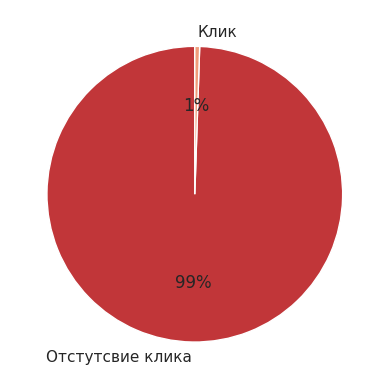

In [12]:
plt.pie(
    df.filter(pl.col('sample') <= 1)['target'].to_pandas().value_counts(),
    labels=['Отстутсвие клика', 'Клик'],  
    startangle=90,      
    autopct='%1.f%%',
);

Целевая переменная имеет очень низкую частоту определенного класса (в данном случае "клик"), это говорит о несбалансированности целевой переменной. В вашем случае, если только 1% записей содержит метку "клик", это создает определенные проблемы, связанные с обучением моделей машинного обучения. 
В дальнейшем надо будет использовать добавление весов для классов, чтобы справиться с проблемрой несбалансированных данных.

In [13]:
# Создадим переменные, в которых будем хранить числовые и категориальные признаки
cat_cols = []
num_cols = []

# Посчитаем CTR каждого юзера относительно рекламной кампании за прошедший день.

Для каждого дня посчитаем кумулятивное количество кликов и показов каждого рекламного объявления. Далее посчитаем ctr и сместим значения на 1 вниз, чтобы избежать утечки данных

In [14]:
# Группируем данные по user_id, adv_campaign_id и event_date, агрегация результатов:
# - Считаем общее количество кликов (сумма target) и общее количество показов (количество записей) для каждой группы.
# Затем сортируем результат по user_id, adv_campaign_id и event_date.
sorted_df = df.group_by(['user_id', 'adv_campaign_id', 'event_date']).agg([
    pl.sum('target').alias('clicks'),
    pl.col('target').count().alias('shows')]).sort(by=['user_id', 'adv_campaign_id', 'event_date'])

# Рассчитываем кумулятивные суммы кликов и показов по группам user_id и adv_campaign_id
cumsum_clicks_shows = (
    sorted_df.with_columns([
        pl.col('clicks').cum_sum().over(['user_id', 'adv_campaign_id']).alias('cumsum_user_campaign_clicks'),
        pl.col('shows').cum_sum().over(['user_id', 'adv_campaign_id']).alias('cumsum_user_campaign_shows')
    ])
)

# Вычисляем CTR (Click-Through Rate) как отношение кумулятивных кликов к кумулятивным показам
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    (pl.col('cumsum_user_campaign_clicks') / pl.col('cumsum_user_campaign_shows')).alias('ctr_user_campaign')
)

# Сдвигаем значение CTR на 1 позицию вниз, чтобы сохранить предыдущий CTR для каждой группы
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('ctr_user_campaign').shift().over(['user_id', 'adv_campaign_id']).alias('ctr_user_campaign')
)

# Сдвигаем значение показы на 1 позицию вниз, чтобы сохранить предыдущий CTR для каждой группы
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('cumsum_user_campaign_shows').shift().over(['user_id', 'adv_campaign_id']).alias('cumsum_user_campaign_shows')
)

cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('cumsum_user_campaign_clicks').shift().over(['user_id', 'adv_campaign_id']).alias('cumsum_user_campaign_clicks')
)

# Заполняем возможные NULL значения в CTR нулями (0.0)
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('ctr_user_campaign').fill_null(0.0),
    pl.col('cumsum_user_campaign_shows').fill_null(0),
     pl.col('cumsum_user_campaign_clicks').fill_null(0)
)

In [15]:
# Соединяем с исхлжным датафреймом
df = df.join(cumsum_clicks_shows[['user_id','adv_campaign_id', 'event_date','ctr_user_campaign', 'cumsum_user_campaign_shows', 'cumsum_user_campaign_clicks']], on=['user_id', 'adv_campaign_id', 'event_date'], how='left')

In [104]:
# Добавляем константу для модели
X = sm.add_constant(df.filter(pl.col('sample')==1)['ctr_user_campaign'].to_numpy())
y = df.filter(pl.col('sample')==1)['target'].to_numpy()
model = sm.Logit(y, X)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.033360
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:            114741035
Model:                          Logit   Df Residuals:                114741033
Method:                           MLE   Df Model:                            1
Date:                Wed, 18 Dec 2024   Pseudo R-squ.:                0.001884
Time:                        10:20:48   Log-Likelihood:            -3.8277e+06
converged:                       True   LL-Null:                   -3.8349e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.2321      0.001  -4071.061      0.000      -5.235      -5.230
x1             2.0662      0.

"ctr_user_campaign" имеет положительный и значимый коэффициент (2.0662). Это означает, что этот признак имеет влияние на вероятность клика, и увеличение его значения соответствует увеличению вероятности положительного исхода.

P-значение для ctr_user_campaign показывает, что этот признак статистически значим (p < 0.0001). Это говорит о том, что есть высокая вероятность, что наблюдаемое влияние этого признака не является случайным.

# Посчитаем CTR каждого юзера относительно логической категории за прошедший день.

Это покажет как изменялось отношения пользователя к каждой логической категории за прошедший день.

In [16]:
# Группируем данные по user_id, logcat_id и event_date, агрегация результатов:
# - Считаем общее количество кликов (сумма target) и общее количество показов (количество записей) для каждой группы.
# Затем сортируем результат по user_id, logcat_id и event_date.
sorted_df = df.group_by(['user_id', 'logcat_id', 'event_date']).agg([
    pl.sum('target').alias('clicks'),  # Количество кликов
    pl.col('target').count().alias('shows')  # Количество показов
]).sort(by=['user_id', 'logcat_id', 'event_date'])

# Рассчитываем кумулятивные суммы кликов и показов по группам user_id и logcat_id
cumsum_clicks_shows = (
    sorted_df.with_columns([
        pl.col('clicks').cum_sum().over(
            [
                'user_id', 'logcat_id'
            ]
        ).alias('cumsum_user_logcat_clicks'),  # Кумулятивные клики
        pl.col('shows').cum_sum().over(
            [
                'user_id', 'logcat_id'
            ]
        ).alias('cumsum_user_logcat_shows')  # Кумулятивные показы
    ])
)

# Вычисляем CTR (Click-Through Rate) как отношение кумулятивных кликов к кумулятивным показам
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    (pl.col('cumsum_user_logcat_clicks') / pl.col('cumsum_user_logcat_shows')).alias('ctr_user_logcat')
)

# Сдвигаем значение CTR на 1 позицию вниз, чтобы сохранить предыдущий CTR для каждой группы
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('ctr_user_logcat').shift().over(['user_id', 'logcat_id']).alias('ctr_user_logcat')
)

cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('cumsum_user_logcat_shows').shift().over(['user_id', 'logcat_id']).alias('cumsum_user_logcat_shows')
)

# Заполняем возможные NULL значения в CTR нулями (0.0)
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('ctr_user_logcat').fill_null(0.0)
)
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('cumsum_user_logcat_shows').fill_null(0)
)

In [17]:
# Соединяем с исходным датафреймом
df = df.join(cumsum_clicks_shows[['user_id','logcat_id', 'event_date', 'cumsum_user_logcat_shows', 'ctr_user_logcat']], on=['user_id','logcat_id', 'event_date'], how='left')

In [105]:
ctr_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 1))['ctr_user_logcat']
ctr_no_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 0))['ctr_user_logcat']

t_stat, p_value = stats.ttest_ind(ctr_likes, ctr_no_likes)

print(f't-статистика: {t_stat}, p-значение: {p_value}')

t-статистика: 256.7744643160323, p-значение: 0.0


Существует значительная разница в ctr_user_logcat между пользователями, которые кликают (target == 1), и теми, кто не кликает (target == 0). Это может указывать на то, что пользователи, которые взаимодействуют с рекламной кампанией, таким образом, имеют более высокий уровень кликов по сравнению с теми, кто не проявляет активность.

P-значение 0.0 (или практически 0) указывает на то, что результат статистически значим. Отвергаем нулевую гипотезу, которая утверждает, что две группы не имеют значительных различий. В вашем случае можно сказать, что есть очень сильные доказательства против нулевой гипотезы, и можно заключить, что ctr_user_logcat значительно различается между группами пользователей.

# Укажем был ли это первый показ этой рекламной кампании этому юзеру

In [18]:
# Выбираем только нужные столбцы из исходного DataFrame и сортируем его
# по user_id, adv_campaign_id и event_date.
sorted_df = df[['user_id', 'adv_campaign_id', 'event_date', 'target']].sort(by=[
    'user_id', 'adv_campaign_id', 'event_date'
])

# Добавляем новый столбец 'is_first_show_adv_campaign_for_user',
# в который для начала занесем количество показов рекламного объявления к конкретному дню
cumsum_shows = sorted_df.with_columns(
    pl.col('target').cum_count().over(
        [
            'user_id', 'adv_campaign_id'  # Кумулятивный подсчет показов по группам
        ]
    ).alias('is_first_show_adv_campaign_for_user')
)

# Фильтруем DataFrame, оставляя только те строки, где
# 'is_first_show_adv_campaign_for_user' равно 1, т.е. это первый показ
# рекламной кампании для данного пользователя.
cumsum_shows = cumsum_shows.filter(pl.col('is_first_show_adv_campaign_for_user') == 1)

In [19]:
# Соединяем с исходным датафреймом
df = df.join(cumsum_shows[['user_id','adv_campaign_id', 'event_date', 'is_first_show_adv_campaign_for_user']], on=['user_id','adv_campaign_id', 'event_date'], how='left')

#  Заполняем пропуски в новом признаке.
df = df.with_columns(
    pl.col('is_first_show_adv_campaign_for_user').fill_null(0)
)

Теперь проверим есть ли статистическая значимость в новом признаке.

In [20]:
import scipy.stats as stats

# создаем таблицу сопряженности
df1 = df.filter(pl.col('sample') == 1)[['target', 'is_first_show_adv_campaign_for_user']].to_pandas()
contingency_table = pd.crosstab(df1['target'], df1['is_first_show_adv_campaign_for_user'])

# вычисляем критерий Хи-квадрат
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print("Критерий Хи-квадрат:", chi2)
print("p-value:", p)

Критерий Хи-квадрат: 3235.8768384287346
p-value: 0.0


Существует статистически значимая связь между тем, является ли показ рекламы первым для пользователя (is_first_show_adv_campaign_for_user) и фактом взаимодействия с этой рекламой (значением target). Это может означать, что пользователи, для которых реклама является первой, имеют вероятность взаимодействия с ней (например, клик) иным образом по сравнению с теми, кто уже видел рекламу ранее.

# Выделим из даты номер недели в году

In [21]:
 df = df.with_columns(
     pl.col('event_date').dt.week().alias('week')
 )

# Посчитаем недельный CTR для каждого юзера относительно каждой рекламной кампании за прошедшую неделю.

In [22]:
# Группируем данные по user_id, adv_campaign_id и неделе (week).
# Агрегируем результаты: 
# - Считаем общее количество кликов (сумма значений target) за неделю для каждого пользователя и рекламной кампании. 
# - Считаем общее количество показов (количество записей) за неделю.
week_clicks_shows = (
    df.group_by(['user_id', 'adv_campaign_id', 'week']).agg([
        pl.col('target').sum().alias('user_adv_campaign_clicks_week'),  # Кумулятивные клики
        pl.len().alias('user_adv_campaign_shows_week')  # Кумулятивные показы
    ])
)

# Вычисляем CTR (Click-Through Rate) как отношение кликов к показам за неделю.
week_clicks_shows = week_clicks_shows.with_columns(
    (pl.col('user_adv_campaign_clicks_week') / pl.col('user_adv_campaign_shows_week')).alias('ctr_user_adv_campaign_week')
)

# Сортируем результат по user_id, adv_campaign_id и неделе.
week_clicks_shows = week_clicks_shows.sort(by=['user_id', 'adv_campaign_id', 'week'])


# Сдвигаем значения CTR на одну позицию вниз, чтобы сохранить CTR за предыдущую неделю для каждой группы.
week_clicks_shows = week_clicks_shows.with_columns([
    pl.col('ctr_user_adv_campaign_week').shift().over(
        ['user_id', 'adv_campaign_id']  # Сдвиг по пользователю и рекламной кампании
    ).alias('shift_ctr_user_adv_campaign_week')  # Переименовываем результат
])

In [23]:
# Заполняем возможные NULL значения в сдвинутом CTR и кликах нулями (0.0).
week_clicks_shows = week_clicks_shows.with_columns(
    pl.col('shift_ctr_user_adv_campaign_week').fill_null(0.0))

In [24]:
df = df.join(week_clicks_shows[['user_id', 'adv_campaign_id', 'week', 'shift_ctr_user_adv_campaign_week']],  on=['user_id', 'adv_campaign_id', 'week'], how='left')

In [106]:
ctr_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 1))['shift_ctr_user_adv_campaign_week']
ctr_no_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 0))['shift_ctr_user_adv_campaign_week']

t_stat, p_value = stats.ttest_ind(ctr_likes, ctr_no_likes)

print(f't-статистика: {t_stat}, p-значение: {p_value}')

t-статистика: 100.21044739330542, p-значение: 0.0


p-значение 0.0 (или практически 0) говорит о том, что результат статистически значим. Оотвергаем нулевую гипотезу, предполагающую, что средние значения двух групп равны. В вашем случае это означает, что существует значительная разница между средними значениями shift_ctr_user_adv_campaign_week для пользователей, которые кликают, и теми, кто нет.

# Посчитаем недельный CTR для каждого юзера относительно каждой логической за прошедшую неделю.

In [25]:
# Группируем данные по user_id,logcat_id и неделе (week).
# Агрегируем результаты: 
# - Считаем общее количество кликов (сумма значений target) за неделю для каждого пользователя и рекламной кампании. 
# - Считаем общее количество показов (количество записей) за неделю.
week_clicks_shows = (
    df.group_by(['user_id', 'logcat_id', 'week']).agg([
        pl.col('target').sum().alias('user_logcat_clicks_week'),  # Кумулятивные клики
        pl.len().alias('user_logcat_shows_week')  # Кумулятивные показы
    ])
)

# Вычисляем CTR (Click-Through Rate) как отношение кликов к показам за неделю.
week_clicks_shows = week_clicks_shows.with_columns(
    (pl.col('user_logcat_clicks_week') / pl.col('user_logcat_shows_week')).alias('ctr_user_logcat_week')
)

# Сортируем результат по user_id, adv_campaign_id и неделе.
week_clicks_shows = week_clicks_shows.sort(by=['user_id', 'logcat_id', 'week'])


# Сдвигаем значения CTR на одну позицию вниз, чтобы сохранить CTR за предыдущую неделю для каждой группы.
week_clicks_shows = week_clicks_shows.with_columns([
    pl.col('ctr_user_logcat_week').shift().over(
        ['user_id', 'logcat_id']  # Сдвиг по пользователю и рекламной кампании
    ).alias('shift_ctr_user_logcat_week')  # Переименовываем результат
])

# Заполняем возможные NULL значения в сдвинутом CTR и кликах нулями (0.0).
week_clicks_shows = week_clicks_shows.with_columns(
    pl.col('shift_ctr_user_logcat_week').fill_null(0.0),  # Заменяем NULL на 0.0
)

In [26]:
df = df.join(week_clicks_shows[['user_id', 'logcat_id', 'week', 'shift_ctr_user_logcat_week']],  on=['user_id', 'logcat_id', 'week'], how='left')

In [107]:
ctr_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 1))['shift_ctr_user_logcat_week']
ctr_no_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 0))['shift_ctr_user_logcat_week']

t_stat, p_value = stats.ttest_ind(ctr_likes, ctr_no_likes)

print(f't-статистика: {t_stat}, p-значение: {p_value}')

t-статистика: 175.1406208126204, p-значение: 0.0


Существует значительная разница в shift_ctr_user_logcat_week между пользователями, которые ставят лайки (target == 1), и теми, кто не ставит лайки (target == 0). Это может означать, что пользователи, которые лайкают, проявляют более высокий уровень взаимодействия или вовлеченности в отношении контента, связанного с shift_ctr_user_logcat_week.

# Считаем общий CTR рекламной кампании к предыдущим дням.

In [27]:
# Группируем данные по adv_campaign_id и event_date.
# Агрегируем результаты: 
# - Считаем общее количество кликов (сумма значений target) и общее количество показов (количество записей) для каждой группы.
# Затем сортируем результат по adv_campaign_id и event_date.
sorted_df = df.group_by(['adv_campaign_id', 'event_date']).agg([
    pl.sum('target').alias('clicks'),  # Кумулятивные клики
    pl.col('target').count().alias('shows')  # Кумулятивные показы
]).sort(by=['adv_campaign_id', 'event_date'])

# Рассчитываем кумулятивные суммы кликов и показов по группам adv_campaign_id
cumsum_clicks_shows = (
    sorted_df.with_columns([
        pl.col('clicks').cum_sum().over(
            [
                'adv_campaign_id'
            ]
        ).alias('cumsum_adv_campaign_clicks'),  # Кумулятивные клики по рекламной кампании
        pl.col('shows').cum_sum().over(
            [
                'adv_campaign_id'
        ]
        ).alias('cumsum_adv_campaign_shows')  # Кумулятивные показы по рекламной кампании
    ])
)

# Вычисляем CTR (Click-Through Rate) как отношение кумулятивных кликов к кумулятивным показам
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    (pl.col('cumsum_adv_campaign_clicks') / pl.col('cumsum_adv_campaign_shows')).alias('ctr_adv_campaign')
)

# Сдвигаем значение CTR на 1 позицию вниз, чтобы сохранить предыдущий CTR для каждой группы
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('ctr_adv_campaign').shift().over(['adv_campaign_id']).alias('ctr_adv_campaign')
)

# Заполняем возможные NULL значения в CTR нулями (0.0)
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('ctr_adv_campaign').fill_null(0.0)
)

In [28]:
df = df.join(cumsum_clicks_shows[['adv_campaign_id', 'event_date', 'ctr_adv_campaign']], on=['adv_campaign_id', 'event_date'], how='left')

In [108]:
ctr_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 1))['ctr_adv_campaign']
ctr_no_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 0))['ctr_adv_campaign']

t_stat, p_value = stats.ttest_ind(ctr_likes, ctr_no_likes)

print(f't-статистика: {t_stat}, p-значение: {p_value}')

t-статистика: 213.92636890669323, p-значение: 0.0


p-значение 0.0 подтверждает, что разница между группами статистически значима. 

# Считаем общий CTR баннера к предыдущим дням.

In [29]:
# Группируем данные по banner_code и event_date.
# Агрегируем результаты: 
# - Считаем общее количество кликов (сумма значений target) и общее количество показов (количество записей) для каждой группы.
# Затем сортируем результат по banner_code и event_date.
sorted_df = df.group_by(['banner_code', 'event_date']).agg([
    pl.sum('target').alias('clicks'),  # Кумулятивные клики
    pl.col('target').count().alias('shows')  # Кумулятивные показы
]).sort(by=['banner_code', 'event_date'])

# Рассчитываем кумулятивные суммы кликов и показов по группам banner_code
cumsum_clicks_shows = (
    sorted_df.with_columns([
        pl.col('clicks').cum_sum().over(
            [
                'banner_code'  # Кумулятивный подсчет по banner_code
            ]
        ).alias('cumsum_banner_clicks'),  # Кумулятивные клики по баннеру
        pl.col('shows').cum_sum().over(
            [
                'banner_code'  # Кумулятивный подсчет по banner_code
            ]
        ).alias('cumsum_banner_shows')  # Кумулятивные показы по баннеру
    ])
)

# Вычисляем CTR (Click-Through Rate) как отношение кумулятивных кликов к кумулятивным показам
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    (pl.col('cumsum_banner_clicks') / pl.col('cumsum_banner_shows')).alias('ctr_banner')  # Расчет CTR
)

# Сдвигаем значение CTR на одну позицию вниз, чтобы сохранить предыдущий CTR для каждого баннера
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('ctr_banner').shift().over(['banner_code']).alias('ctr_banner')  # Предыдущее значение CTR
)

# Заполняем возможные NULL значения в CTR нулями (0.0)
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('ctr_banner').fill_null(0.0)  # Замена NULL на 0.0
)

In [30]:
df = df.join(cumsum_clicks_shows[['banner_code', 'event_date', 'ctr_banner']], on=['banner_code', 'event_date'], how='left')

In [109]:
ctr_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 1))['ctr_banner']
ctr_no_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 0))['ctr_banner']

t_stat, p_value = stats.ttest_ind(ctr_likes, ctr_no_likes)

print(f't-статистика: {t_stat}, p-значение: {p_value}')

t-статистика: 342.58564985019996, p-значение: 0.0


p-значение 0.0 подтверждает, что разница между группами статистически значима. 

In [31]:
# Группируем данные по user_id, banner_code и event_date.
# Агрегируем результаты: 
# - Считаем общее количество кликов (сумма значений target) и общее количество показов (количество записей) для каждой группы.
# Затем сортируем результат по user_id, banner_code и event_date.
sorted_df = df.group_by(['user_id', 'banner_code', 'event_date']).agg([
    pl.sum('target').alias('clicks'),  # Кумулятивные клики
    pl.col('target').count().alias('shows')  # Кумулятивные показы
]).sort(by=['user_id', 'banner_code', 'event_date'])

# Рассчитываем кумулятивные суммы кликов и показов по группам banner_code
cumsum_clicks_shows = (
    sorted_df.with_columns([
        pl.col('clicks').cum_sum().over(
            [
                'user_id', 'banner_code'  # Кумулятивный подсчет по banner_code
            ]
        ).alias('cumsum_banner_clicks'),  # Кумулятивные клики по баннеру
        pl.col('shows').cum_sum().over(
            [
                'user_id', 'banner_code'  # Кумулятивный подсчет по banner_code
            ]
        ).alias('cumsum_banner_shows')  # Кумулятивные показы по баннеру
    ])
)

# Вычисляем CTR (Click-Through Rate) как отношение кумулятивных кликов к кумулятивным показам
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    (pl.col('cumsum_banner_clicks') / pl.col('cumsum_banner_shows')).alias('ctr_banner_us')  # Расчет CTR
)

# Сдвигаем значение CTR на одну позицию вниз, чтобы сохранить предыдущий CTR для каждого баннера
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('ctr_banner_us').shift().over(['user_id', 'banner_code']).alias('ctr_banner_us')  # Предыдущее значение CTR
)

# Заполняем возможные NULL значения в CTR нулями (0.0)
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('ctr_banner_us').fill_null(0.0)  # Замена NULL на 0.0
)

In [32]:
df = df.join(cumsum_clicks_shows[['user_id', 'banner_code', 'event_date', 'ctr_banner_us']], on=['user_id', 'banner_code', 'event_date'], how='left')

In [110]:
ctr_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 1))['ctr_banner_us']
ctr_no_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 0))['ctr_banner_us']

t_stat, p_value = stats.ttest_ind(ctr_likes, ctr_no_likes)

print(f't-статистика: {t_stat}, p-значение: {p_value}')

t-статистика: 448.2996533787308, p-значение: 0.0


p-значение 0.0 подтверждает, что разница между группами статистически значима. 

In [33]:
# Группируем данные по 'user_id', 'banner_code', 'week'
# Агрегируем результаты: 
# - Считаем общее количество кликов (сумма значений target) и общее количество показов (количество записей) для каждой группы.
# Затем сортируем результат по 'user_id', 'banner_code', 'week'
sorted_df = df.group_by(['user_id', 'banner_code', 'week']).agg([
    pl.sum('target').alias('clicks'),  # Кумулятивные клики
    pl.col('target').count().alias('shows')  # Кумулятивные показы
]).sort(by=['user_id', 'banner_code', 'week'])

# Рассчитываем кумулятивные суммы кликов и показов по группам banner_code
cumsum_clicks_shows = (
    sorted_df.with_columns([
        pl.col('clicks').cum_sum().over(
            [
                'user_id', 'banner_code'  
            ]
        ).alias('cumsum_banner_clicks'), 
        pl.col('shows').cum_sum().over(
            [
                'user_id', 'banner_code' 
            ]
        ).alias('cumsum_banner_shows')
    ])
)

# Вычисляем CTR (Click-Through Rate) как отношение кумулятивных кликов к кумулятивным показам
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    (pl.col('cumsum_banner_clicks') / pl.col('cumsum_banner_shows')).alias('ctr_banner_us_week')  # Расчет CTR
)

# Сдвигаем значение CTR на одну позицию вниз, чтобы сохранить предыдущий CTR для каждого баннера
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('ctr_banner_us_week').shift().over(['user_id', 'banner_code']).alias('ctr_banner_us_week')  # Предыдущее значение CTR
)

# Заполняем возможные NULL значения в CTR нулями (0.0)
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('ctr_banner_us_week').fill_null(0.0)  # Замена NULL на 0.0
)

In [34]:
df = df.join(cumsum_clicks_shows[['user_id', 'banner_code', 'week', 'ctr_banner_us_week']], on=['user_id', 'banner_code', 'week'], how='left')

In [111]:
ctr_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 1))['ctr_banner_us_week']
ctr_no_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 0))['ctr_banner_us_week']

t_stat, p_value = stats.ttest_ind(ctr_likes, ctr_no_likes)

print(f't-статистика: {t_stat}, p-значение: {p_value}')

t-статистика: 340.51837795822183, p-значение: 0.0


Значение p-значения, равное 0.0, позволяет уверенно утверждать, что разница между группами статистически значима. Это показывает, что мы можем отвергнуть нулевую гипотезу, предполагающую отсутствие разницы в CTR между двумя группами пользователей.

# Считаем общий CTR относительно локации на которую распостраняется рекламная кампания к предыдущим дням.

In [35]:
# Группируем данные по location_id и event_date.
# Агрегируем результаты:
# - Считаем общее количество кликов (сумма значений target) и общее количество показов (количество записей) для каждой группы.
# Затем сортируем результат по location_id и event_date.
sorted_df = df.group_by(['location_id', 'event_date']).agg([
    pl.sum('target').alias('clicks'),  # Кумулятивные клики
    pl.col('target').count().alias('shows')  # Кумулятивные показы
]).sort(by=['location_id', 'event_date'])

# Рассчитываем кумулятивные суммы кликов и показов по группам location_id
cumsum_clicks_shows = (
    sorted_df.with_columns([
        pl.col('clicks').cum_sum().over(
            ['location_id']  # Кумулятивный подсчет по location_id
        ).alias('cumsum_location_clicks'),  # Кумулятивные клики по локации
        pl.col('shows').cum_sum().over(
            ['location_id']  # Кумулятивный подсчет по location_id
        ).alias('cumsum_location_shows')  # Кумулятивные показы по локации
    ])
)

# Вычисляем CTR (Click-Through Rate) как отношение кумулятивных кликов к кумулятивным показам
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    (pl.col('cumsum_location_clicks') / pl.col('cumsum_location_shows')).alias('ctr_location')  # Расчет CTR
)

# Сдвигаем значение CTR на одну позицию вниз, чтобы сохранить предыдущий CTR для каждой локации
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('ctr_location').shift().over(['location_id']).alias('ctr_location')  # Предыдущее значение CTR по location_id
)

# Заполняем возможные NULL значения в CTR нулями (0.0)
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('ctr_location').fill_null(0.0)  # Замена NULL на 0.0
)

In [36]:
df = df.join(cumsum_clicks_shows[['location_id', 'event_date', 'ctr_location']], on=['location_id', 'event_date'], how='left')

In [112]:
ctr_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 1))['ctr_location']
ctr_no_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 0))['ctr_location']

t_stat, p_value = stats.ttest_ind(ctr_likes, ctr_no_likes)

print(f't-статистика: {t_stat}, p-значение: {p_value}')

t-статистика: 63.64765262315671, p-значение: 0.0


Значение p-значения, равное 0.0, позволяет уверенно утверждать, что разница между группами статистически значима.

# Извлекаем номер дня недели и номер недели в самом месяце

In [37]:
df = df.with_columns(
    pl.col('event_date').dt.weekday().cast(pl.Int8).alias('day_of_week'),
    (pl.col('event_date').dt.day() / 7).ceil().cast(pl.Int8).alias('week_of_month')
)

# Смотрим на распределение target в зависимости от дня недели

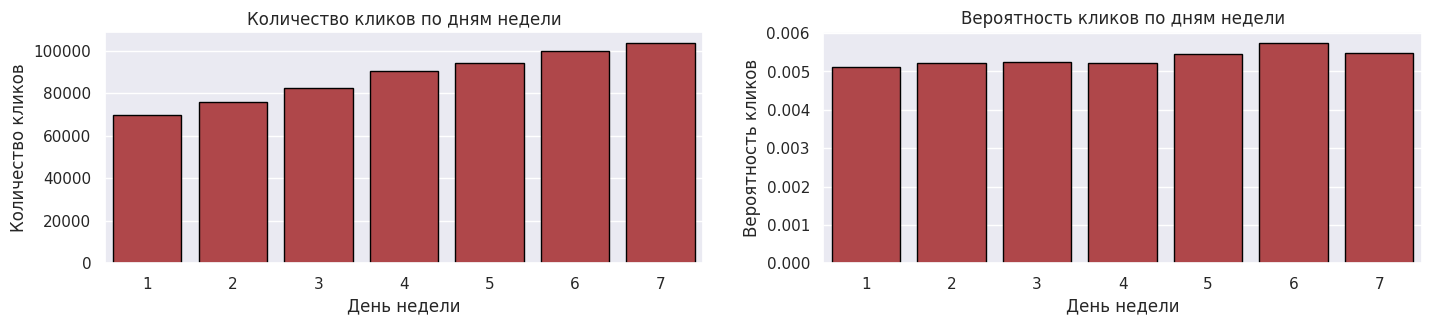

In [38]:
#Группируем данные по дням недели и считаем количество кликов
clicks_by_day = df.filter(pl.col('sample') == 1).group_by("day_of_week").agg([pl.mean("target").alias('mean'),
                                                                             pl.sum("target").alias('sum')])
# Превращаем Polars DataFrame в Pandas DataFrame для удобства использования с Matplotlib
pd_df = clicks_by_day.to_pandas().sort_values(by='day_of_week')
# Строим столбчатую диаграмму
fig, axes = plt.subplots(1, 2, figsize=(17, 3))

sns.barplot(pd_df, x='day_of_week', y='sum', edgecolor='black', ax=axes[0])
axes[0].set_xlabel('День недели')
axes[0].set_ylabel('Количество кликов')
axes[0].set_title('Количество кликов по дням недели');

sns.barplot(pd_df, x='day_of_week', y='mean', edgecolor='black', ax=axes[1])
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('Вероятность кликов')
axes[1].set_title('Вероятность кликов по дням недели');
plt.show();

Из графиков видно, что количество кликов растет к концу недели, и в целом вероятность кликов в конце недели становится выше. Значит такой признак нам пригодится для предсказания.

# Смотрим на распределение target в зависимости от номера недели

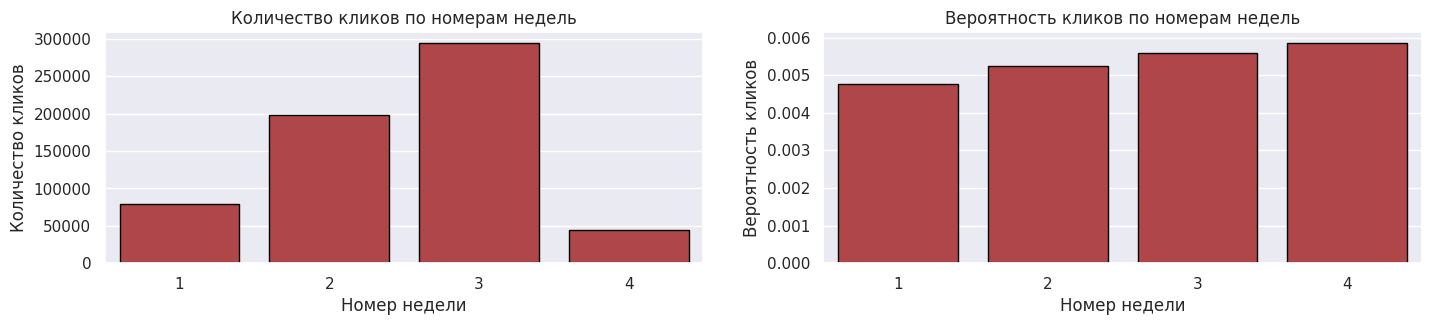

In [39]:
#Группируем данные по дням недели и считаем количество кликов
clicks_by_day = df.filter(pl.col('sample') == 1).group_by("week_of_month").agg([pl.mean("target").alias('mean'),
                                                                             pl.sum("target").alias('sum')])
# Превращаем Polars DataFrame в Pandas DataFrame для удобства использования с Matplotlib
pd_df = clicks_by_day.to_pandas().sort_values(by='week_of_month')
# Строим столбчатую диаграмму
fig, axes = plt.subplots(1, 2, figsize=(17, 3))

sns.barplot(pd_df, x='week_of_month', y='sum', edgecolor='black', ax=axes[0])
axes[0].set_xlabel('Номер недели')
axes[0].set_ylabel('Количество кликов')
axes[0].set_title('Количество кликов по номерам недель');

sns.barplot(pd_df, x='week_of_month', y='mean', edgecolor='black', ax=axes[1])
axes[1].set_xlabel('Номер недели')
axes[1].set_ylabel('Вероятность кликов')
axes[1].set_title('Вероятность кликов по номерам недель');
plt.show();

Больше всего совершается кликов в середине месяца, а вероятность кликов возрастает к концу месяца. Так как значения для каждого номера недели сильно варьируются, будем использовать этот признак.

# Создаем 2 новых признака:

* Является ли день показа субботой
* Является ли день показа пятницей или воскресеньем

In [40]:
df = df.with_columns(
     (pl.col("day_of_week") == 6).cast(pl.Int8).alias("is_saturday"), 
    ((pl.col("day_of_week") == 5) | (pl.col("day_of_week") == 7)).cast(pl.Int8).alias("is_fri_or_sund")
)

Проверяем статистическую важность зависимостей между целевой переменной и новыми признаками

In [41]:
d = df.filter(pl.col('sample')==1)

# Строим таблицу сопряженности
contingency_table = pd.crosstab(d['target'], d['is_saturday'])

# Применяем критерий Хи-квадрат
chi2, p, dof, expected = chi2_contingency(contingency_table)

if p < 0.05:
    print("Существует статистически значимая зависимость между кликом и субботой")
else:
    print("Нет статистически значимой зависимости между кликом и субботой")

Существует статистически значимая зависимость между кликом и субботой


In [42]:
# Строим таблицу сопряженности
contingency_table = pd.crosstab(d['target'], d['is_fri_or_sund'])

# Применяем критерий Хи-квадрат
chi2, p, dof, expected = chi2_contingency(contingency_table)

if p < 0.05:
    print("Существует статистически значимая зависимость между кликом и пятницей/воскресеньем")
else:
    print("Нет статистически значимой зависимости между кликом и пятницей/воскресеньем")

Существует статистически значимая зависимость между кликом и пятницей/воскресеньем


In [43]:
d = df.filter(pl.col('sample')==1)

# Строим таблицу сопряженности
contingency_table = pd.crosstab(d['target'], d['week_of_month'])

# Применяем критерий Хи-квадрат
chi2, p, dof, expected = chi2_contingency(contingency_table)

if p < 0.05:
    print("Существует статистически значимая зависимость между кликом и номером недели")
else:
    print("Нет статистически значимой зависимости между кликом и номером недели")

Существует статистически значимая зависимость между кликом и номером недели


# Считаем продолжительность рекламной кампании

In [44]:
df = df.with_columns(
    ((pl.col("end_date") - pl.col("start_date")).dt.total_seconds() / (60 * 60 * 24) + 1).cast(pl.Int8).alias("duration_days")
)

In [113]:
ctr_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 1))['duration_days']
ctr_no_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 0))['duration_days']

t_stat, p_value = stats.ttest_ind(ctr_likes, ctr_no_likes)

print(f't-статистика: {t_stat}, p-значение: {p_value}')

t-статистика: -37.42657280887384, p-значение: 1.451008054613537e-306


Существование значительной разницы в duration_days между пользователями, которые совершает клик, и теми, кто нет. Пользователи, которые кликают, имеют меньшее среднемесячное время взаимодействия (duration_days), чем пользователи, которые не кликают.

# Считаем сколько дней прошло со старта кампании до показа пользователю

In [45]:
df = df.with_columns(
    ((pl.col("event_date") - pl.col("start_date")).dt.total_seconds() / (60 * 60 * 24) + 1).cast(pl.Int8).alias('days_since_campaign_start')
)
df = df.with_columns(
    pl.when(pl.col("days_since_campaign_start") > pl.col("duration_days"))
     .then("duration_days")
     .otherwise(pl.col("days_since_campaign_start"))
     .alias("days_since_campaign_start")
)

In [114]:
ctr_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 1))['days_since_campaign_start']
ctr_no_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 0))['days_since_campaign_start']

t_stat, p_value = stats.ttest_ind(ctr_likes, ctr_no_likes)

print(f't-статистика: {t_stat}, p-значение: {p_value}')

t-статистика: -40.80979152425087, p-значение: 0.0


Значение p-значения, свидетельствует о том, что разница между группами является статистически значимой

# Считаем CTR каждого пользователя к прошедшим дням.

In [46]:
# Группируем данные по user_id и event_date.
# Агрегируем результаты:
# - Считаем общее количество кликов (сумма значений target) и общее количество показов (количество записей) для каждой группы.
# Затем сортируем результат по user_id и event_date.
sorted_df = df.group_by(['user_id', 'event_date']).agg([
    pl.sum('target').alias('clicks'),  # Кумулятивные клики
    pl.col('target').count().alias('shows')  # Кумулятивные показы
]).sort(by=['user_id', 'event_date'])

# Рассчитываем кумулятивные суммы кликов и показов по группам user_id
cumsum_clicks_shows = (
    sorted_df.with_columns([
        pl.col('clicks').cum_sum().over(
            ['user_id']  # Кумулятивный подсчет по user_id
        ).alias('cumsum_user_clicks'),  # Кумулятивные клики по пользователю
        pl.col('shows').cum_sum().over(
            ['user_id']  # Кумулятивный подсчет по user_id
        ).alias('cumsum_user_shows')  # Кумулятивные показы по пользователю
    ])
)

# Вычисляем CTR (Click-Through Rate) как отношение кумулятивных кликов к кумулятивным показам
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    (pl.col('cumsum_user_clicks') / pl.col('cumsum_user_shows')).alias('ctr_user')  # Расчет CTR
)

# Сдвигаем значение CTR на одну позицию вниз, чтобы сохранить предыдущий CTR для каждого пользователя
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('ctr_user').shift().over(['user_id']).alias('ctr_user')  # Предыдущее значение CTR по user_id
)

# Заполняем возможные NULL значения в CTR нулями (0.0)
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('ctr_user').fill_null(0.0)  # Замена NULL на 0.0
)


In [47]:
df = df.join(cumsum_clicks_shows[['user_id', 'event_date', 'ctr_user']], on=['user_id', 'event_date'], how='left')

In [115]:
ctr_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 1))['ctr_user']
ctr_no_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 0))['ctr_user']

t_stat, p_value = stats.ttest_ind(ctr_likes, ctr_no_likes)

print(f't-статистика: {t_stat}, p-значение: {p_value}')

t-статистика: 313.6550809138298, p-значение: 0.0


Значение p-значения, свидетельствует о том, что разница между группами является статистически значимой

# Считаем CTR каждого пользователя к прошедшей неделе.

In [48]:
# Группируем данные по user_id и week.
# Агрегируем результаты:
# - Считаем общее количество кликов (сумма значений target) и общее количество показов (количество записей) для каждой группы.
# Затем сортируем результат по user_id и week.
sorted_df = df.group_by(['user_id', 'week']).agg([
    pl.sum('target').alias('clicks'),  # Кумулятивные клики
    pl.col('target').count().alias('shows')  # Кумулятивные показы
]).sort(by=['user_id', 'week'])

# Рассчитываем кумулятивные суммы кликов и показов по группам user_id
cumsum_clicks_shows = (
    sorted_df.with_columns([
        pl.col('clicks').cum_sum().over(
            ['user_id']  # Кумулятивный подсчет по user_id
        ).alias('cumsum_user_clicks'),  # Кумулятивные клики по пользователю
        pl.col('shows').cum_sum().over(
            ['user_id']  # Кумулятивный подсчет по user_id
        ).alias('cumsum_user_shows')  # Кумулятивные показы по пользователю
    ])
)

# Вычисляем CTR (Click-Through Rate) как отношение кумулятивных кликов к кумулятивным показам
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    (pl.col('cumsum_user_clicks') / pl.col('cumsum_user_shows')).alias('ctr_user_week')  # Расчет CTR
)

# Сдвигаем значение CTR на одну позицию вниз, чтобы сохранить предыдущий CTR для каждого пользователя
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('ctr_user_week').shift().over(['user_id']).alias('ctr_user_week')  # Предыдущее значение CTR по user_id
)

# Заполняем возможные NULL значения в CTR нулями (0.0)
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('ctr_user_week').fill_null(0.0)  # Замена NULL на 0.0
)


In [49]:
df = df.join(cumsum_clicks_shows[['user_id', 'week', 'ctr_user_week']], on=['user_id', 'week'], how='left')

In [116]:
ctr_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 1))['ctr_user_week']
ctr_no_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 0))['ctr_user_week']

t_stat, p_value = stats.ttest_ind(ctr_likes, ctr_no_likes)

print(f't-статистика: {t_stat}, p-значение: {p_value}')

t-статистика: 231.2627938310114, p-значение: 0.0


Значение p-значения, свидетельствует о том, что разница между группами является статистически значимой

# Помечаем был ли клик по данной категории у конкретного пользователя за прошедшую неделю

In [50]:
sorted_df = df.group_by(['user_id', 'category_id', 'week']).agg(
    pl.max('target').alias('is_click_category')).sort(by=['user_id', 'category_id', 'week'])


sorted_df = sorted_df.with_columns(
    pl.col('is_click_category').shift().over(['user_id', 'category_id']).alias('is_click_category')
)

sorted_df = sorted_df.with_columns(
    pl.col('is_click_category').fill_null(0)
)

In [51]:
df = df.join(sorted_df[['user_id', 'category_id', 'week', 'is_click_category']], on=['user_id', 'category_id', 'week'], how='left')

In [117]:
# Строим таблицу сопряженности
d = df.filter(pl.col('sample')==1)
contingency_table = pd.crosstab(d['target'], d['is_click_category'])

# Применяем критерий Хи-квадрат
chi2, p, dof, expected = chi2_contingency(contingency_table)

if p < 0.05:
    print("Существует статистически значимая зависимость между кликом и новым признаком")
else:
    print("Нет статистически значимой зависимости между кликом и новым признаком")

Существует статистически значимая зависимость между кликом и новым признаком


# Помечаем был ли клик по данному баннеру у конкретного пользователя за прошедшую неделю

In [52]:
sorted_df = df.group_by(['user_id', 'banner_code', 'week']).agg(
    pl.max('target').alias('is_click_banner_code')).sort(by=['user_id', 'banner_code', 'week'])


sorted_df = sorted_df.with_columns(
    pl.col('is_click_banner_code').shift().over(['user_id', 'banner_code']).alias('is_click_banner_code')
)

sorted_df = sorted_df.with_columns(
    pl.col('is_click_banner_code').fill_null(0)
)

In [53]:
df = df.join(sorted_df[['user_id', 'banner_code', 'week', 'is_click_banner_code']], on=['user_id', 'banner_code', 'week'], how='left')

In [118]:
# Строим таблицу сопряженности
d = df.filter(pl.col('sample')==1)
contingency_table = pd.crosstab(d['target'], d['is_click_banner_code'])

# Применяем критерий Хи-квадрат
chi2, p, dof, expected = chi2_contingency(contingency_table)

if p < 0.05:
    print("Существует статистически значимая зависимость между кликом и новым признаком")
else:
    print("Нет статистически значимой зависимости между кликом и новым признаком")

Существует статистически значимая зависимость между кликом и новым признаком


# Создадим признак в котором отразим на сколько кликов еще остался бюджет каждой рекламной кампании

In [54]:
sorted_df = df.group_by(['adv_campaign_id', 'event_date']).agg(
    pl.sum('target').alias('clicks')).sort(by=['adv_campaign_id', 'event_date'])

cumsum_clicks = (
    sorted_df.with_columns(
    pl.col('clicks').cum_sum().over(
        [
            'adv_campaign_id'
        ]
    ).alias('cumsum_adv_campaign_clicks')))

                   
cumsum_clicks = cumsum_clicks.with_columns(
    pl.col('cumsum_adv_campaign_clicks').shift().over(['adv_campaign_id']).alias('cumsum_adv_campaign_clicks')
)

cumsum_clicks = cumsum_clicks.with_columns(
    pl.col('cumsum_adv_campaign_clicks').fill_null(0.0)
)

df = df.join(cumsum_clicks[['adv_campaign_id', 'event_date', 'cumsum_adv_campaign_clicks']], on=['adv_campaign_id', 'event_date'], how='left')

In [55]:
df = df.with_columns(
    ((pl.col('goal_budget') - (pl.col('goal_cost') * pl.col('cumsum_adv_campaign_clicks'))) / pl.col('goal_cost')).round().alias('budget_balances')
)

In [56]:
correlation = df.filter(pl.col('sample') == 1).select(
    pl.corr('budget_balances', 'target').alias('correlation')
)
print(correlation)

shape: (1, 1)
┌─────────────┐
│ correlation │
│ ---         │
│ f64         │
╞═════════════╡
│ -0.000754   │
└─────────────┘


Есть крайне низкая отрицательная корреляция, хоть признак и не оказывает такого сильного воздействия на целевую переменную, возможно св вокупности с другими признакми он улучшит нашу модель.

# Оценим взаимодействие между баннером и креативом. Это может помочь понять, как определённые баннеры работают с определёнными креативами, и какие комбинации наиболее успешны.
* За прошедший день
* За прошедшую неделю

In [57]:
# Группируем данные по adv_creative_id, banner_code и event_date.
# Агрегируем результаты: 
# - Считаем общее количество кликов (сумма значений target) и общее количество показов (количество записей) для каждой группы.
# Затем сортируем результат по adv_creative_id, banner_code и event_date.
sorted_df = df.group_by(['adv_creative_id', 'banner_code', 'event_date']).agg([
    pl.sum('target').alias('clicks'),  # Кумулятивные клики
    pl.col('target').count().alias('shows')  # Кумулятивные показы
]).sort(by=['adv_creative_id', 'banner_code', 'event_date'])

# Рассчитываем кумулятивные суммы кликов и показов по группам adv_creative_id, banner_code
cumsum_clicks_shows = (
    sorted_df.with_columns([
        pl.col('clicks').cum_sum().over(
            [
               'adv_creative_id', 'banner_code' 
            ]
        ).alias('cumsum_banner_clicks'),
        pl.col('shows').cum_sum().over(
            [
                'adv_creative_id', 'banner_code' 
            ]
        ).alias('cumsum_banner_shows') 
    ])
)

# Вычисляем CTR (Click-Through Rate) как отношение кумулятивных кликов к кумулятивным показам
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    (pl.col('cumsum_banner_clicks') / pl.col('cumsum_banner_shows')).alias('ctr_creative_banner')  # Расчет CTR
)

# Сдвигаем значение CTR на одну позицию вниз, чтобы сохранить предыдущий CTR для каждого баннера
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('ctr_creative_banner').shift().over(['adv_creative_id', 'banner_code']).alias('ctr_creative_banner')  # Предыдущее значение CTR
)

# Заполняем возможные NULL значения в CTR нулями (0.0)
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('ctr_creative_banner').fill_null(0.0)  # Замена NULL на 0.0
)

In [58]:
df = df.join(cumsum_clicks_shows[['adv_creative_id', 'banner_code', 'event_date', 'ctr_creative_banner']], on=['adv_creative_id', 'banner_code', 'event_date'], how='left')

In [119]:
ctr_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 1))['ctr_creative_banner']
ctr_no_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 0))['ctr_creative_banner']

t_stat, p_value = stats.ttest_ind(ctr_likes, ctr_no_likes)

print(f't-статистика: {t_stat}, p-значение: {p_value}')

t-статистика: 331.8306871640555, p-значение: 0.0


In [59]:
# Группируем данные по adv_creative_id, banner_code и week.
# Агрегируем результаты: 
# - Считаем общее количество кликов (сумма значений target) и общее количество показов (количество записей) для каждой группы.
# Затем сортируем результат по adv_creative_id, banner_code и week.
sorted_df = df.group_by(['adv_creative_id', 'banner_code', 'week']).agg([
    pl.sum('target').alias('clicks'),  # Кумулятивные клики
    pl.col('target').count().alias('shows')  # Кумулятивные показы
]).sort(by=['adv_creative_id', 'banner_code', 'week'])

# Рассчитываем кумулятивные суммы кликов и показов по группам adv_creative_id, banner_code
cumsum_clicks_shows = (
    sorted_df.with_columns([
        pl.col('clicks').cum_sum().over(
            [
               'adv_creative_id', 'banner_code' 
            ]
        ).alias('cumsum_banner_clicks'),
        pl.col('shows').cum_sum().over(
            [
                'adv_creative_id', 'banner_code' 
            ]
        ).alias('cumsum_banner_shows') 
    ])
)

# Вычисляем CTR (Click-Through Rate) как отношение кумулятивных кликов к кумулятивным показам
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    (pl.col('cumsum_banner_clicks') / pl.col('cumsum_banner_shows')).alias('ctr_creative_banner_w')  # Расчет CTR
)

# Сдвигаем значение CTR на одну позицию вниз, чтобы сохранить предыдущий CTR для каждого баннера
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('ctr_creative_banner_w').shift().over(['adv_creative_id', 'banner_code']).alias('ctr_creative_banner_w')  # Предыдущее значение CTR
)

# Заполняем возможные NULL значения в CTR нулями (0.0)
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('ctr_creative_banner_w').fill_null(0.0)  # Замена NULL на 0.0
)

In [60]:
df = df.join(cumsum_clicks_shows[['adv_creative_id', 'banner_code', 'week', 'ctr_creative_banner_w']], on=['adv_creative_id', 'banner_code', 'week'], how='left')

In [120]:
ctr_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 1))['ctr_creative_banner_w']
ctr_no_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 0))['ctr_creative_banner_w']

t_stat, p_value = stats.ttest_ind(ctr_likes, ctr_no_likes)

print(f't-статистика: {t_stat}, p-значение: {p_value}')

t-статистика: 117.91546585966502, p-значение: 0.0


Получили еще 2 статистически значимых признака, но следует не забывать, что нужно будет внимательно оценить корреляцию между признаками, чтобы избежать сильной мультиколлинеарности.

# Посмотрим как менялся ctr у каждой рекламной кампании для каждого пользователя в зависимости от того был ли показ с главной страницы или нет.

In [61]:
# Группируем данные по 'user_id', 'adv_campaign_id', 'is_main', 'event_date'
# Агрегируем результаты: 
# - Считаем общее количество кликов (сумма значений target) и общее количество показов (количество записей) для каждой группы.
# Затем сортируем результат по 'user_id', 'adv_campaign_id', 'is_main', 'event_date'
sorted_df = df.group_by(['user_id', 'adv_campaign_id', 'is_main', 'event_date']).agg([
    pl.sum('target').alias('clicks'),  # Кумулятивные клики
    pl.col('target').count().alias('shows')  # Кумулятивные показы
]).sort(by=['user_id', 'adv_campaign_id', 'is_main', 'event_date'])

# Рассчитываем кумулятивные суммы кликов и показов по группам adv_creative_id, banner_code
cumsum_clicks_shows = (
    sorted_df.with_columns([
        pl.col('clicks').cum_sum().over(
            [
               'user_id', 'adv_campaign_id', 'is_main'
            ]
        ).alias('cumsum_banner_clicks'),
        pl.col('shows').cum_sum().over(
            [
                'user_id', 'adv_campaign_id', 'is_main'
            ]
        ).alias('cumsum_banner_shows') 
    ])
)

In [62]:
# Вычисляем CTR (Click-Through Rate) как отношение кумулятивных кликов к кумулятивным показам
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    (pl.col('cumsum_banner_clicks') / pl.col('cumsum_banner_shows')).alias('ctr_us_cam_main')  # Расчет CTR
)

# Сдвигаем значение CTR на одну позицию вниз, чтобы сохранить предыдущий CTR для каждого баннера
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('ctr_us_cam_main').shift().over(['user_id', 'adv_campaign_id', 'is_main']).alias('ctr_us_cam_main')  # Предыдущее значение CTR
)

# Заполняем возможные NULL значения в CTR нулями (0.0)
cumsum_clicks_shows = cumsum_clicks_shows.with_columns(
    pl.col('ctr_us_cam_main').fill_null(0.0)  # Замена NULL на 0.0
)

In [63]:
df = df.join(cumsum_clicks_shows[[ 'user_id', 'adv_campaign_id', 'is_main', 'event_date', 'ctr_us_cam_main']], on=[ 'user_id', 'adv_campaign_id', 'is_main', 'event_date'], how='left')

In [121]:
ctr_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 1))['ctr_us_cam_main']
ctr_no_likes = df.filter((pl.col('sample')==1) & (pl.col('target') == 0))['ctr_us_cam_main']

t_stat, p_value = stats.ttest_ind(ctr_likes, ctr_no_likes)

print(f't-статистика: {t_stat}, p-значение: {p_value}')

t-статистика: 177.3476626667095, p-значение: 0.0


# Посмотрим сколько уникальных рекламных кампаний увидел пользователь до текущей даты

In [ ]:
# Сортируем данные по пользователю и дате
df1 = df.sort(['user_id', 'event_date'])

# Создаем столбец с количеством уникальных рекламных кампаний до текущей даты
# Для этого мы будем использовать кумулятивное промытие (cumulative aggregation)
result_df = (
    df1.group_by(['user_id', 'event_date'])
    .agg(pl.col('adv_campaign_id').n_unique().alias('unique_campaigns'))
    .sort(['user_id', 'event_date'])
)

# Теперь мы добавим кумулятивное количество уникальных кампаний
result_df = result_df.with_columns(
    pl.col('unique_campaigns').cum_sum().over('user_id').alias('total_unique_campaigns_before_today')
)

result_df = result_df.with_columns(
    pl.col('total_unique_campaigns_before_today').shift().over('user_id').fill_null(0).alias('total_unique_campaigns_before_today')
)

In [67]:
df = df.join(result_df[['user_id', 'event_date', 'total_unique_campaigns_before_today']], on=['user_id', 'event_date'], how='left')

In [122]:
correlation = df.filter(pl.col('sample') == 1).select(
    pl.corr('total_unique_campaigns_before_today', 'target').alias('correlation')
)
print(correlation)

shape: (1, 1)
┌─────────────┐
│ correlation │
│ ---         │
│ f64         │
╞═════════════╡
│ -0.00325    │
└─────────────┘


Новый признак имеют очень слабую корреляцию с таргетом, но это все равно свидетельствует о том, что чем больше пользователь уведл рекламных кампаний ранее, тем меньше вероятность его клика.

# Посмотрим сколько уникальных баннеров увидел пользователь до текущей даты

In [68]:
# Сортируем данные по пользователю и дате
df1 = df.sort(['user_id', 'event_date'])

# Создаем столбец с количеством уникальных баннеров до текущей даты
# Для этого мы будем использовать кумулятивное промытие (cumulative aggregation)
result_df = (
    df1.group_by(['user_id', 'event_date'])
    .agg(pl.col('banner_code').n_unique().alias('unique_banners'))
    .sort(['user_id', 'event_date'])
)

# Теперь мы добавим кумулятивное количество уникальных кампаний
result_df = result_df.with_columns(
    pl.col('unique_banners').cum_sum().over('user_id').alias('total_unique_banners_before_today')
)

result_df = result_df.with_columns(
    pl.col('total_unique_banners_before_today').shift().over('user_id').fill_null(0).alias('total_unique_banners_before_today'))
    

# Объединим с оригинальным DataFrame для получения полного результата

df = df.join(result_df[['user_id', 'event_date', 'total_unique_banners_before_today']], on=['user_id', 'event_date'], how='left')

In [123]:
correlation = df.filter(pl.col('sample') == 1).select(
    pl.corr('total_unique_banners_before_today', 'target').alias('correlation')
)
print(correlation)

shape: (1, 1)
┌─────────────┐
│ correlation │
│ ---         │
│ f64         │
╞═════════════╡
│ -0.001052   │
└─────────────┘


Количество увиденных различных баннеров юзером ранее, слабее сказывается на таргете в отличие от признака количества уникальных кампаний, которые увидел пользователь ранее.

# Посмотрим сколько уникальных креативов увидел пользователь до текущей даты

In [69]:
# Сортируем данные по пользователю и дате
df1 = df.sort(['user_id', 'event_date'])

# Создаем столбец с количеством уникальных креативов до текущей даты
# Для этого мы будем использовать кумулятивное промытие (cumulative aggregation)
result_df = (
    df1.group_by(['user_id', 'event_date'])
    .agg(pl.col('adv_creative_id').n_unique().alias('unique_creative'))
    .sort(['user_id', 'event_date'])
)

# Теперь мы добавим кумулятивное количество уникальных кампаний
result_df = result_df.with_columns(
    pl.col('unique_creative').cum_sum().over('user_id').alias('total_unique_creative_before_today')
)

result_df = result_df.with_columns(
    pl.col('total_unique_creative_before_today').shift().over('user_id').fill_null(0).alias('total_unique_creative_before_today'))
    

# Объединим с оригинальным DataFrame для получения полного результата

df = df.join(result_df[['user_id', 'event_date', 'total_unique_creative_before_today']], on=['user_id', 'event_date'], how='left')

In [124]:
correlation = df.filter(pl.col('sample') == 1).select(
    pl.corr('total_unique_creative_before_today', 'target').alias('correlation')
)
print(correlation)

shape: (1, 1)
┌─────────────┐
│ correlation │
│ ---         │
│ f64         │
╞═════════════╡
│ -0.00325    │
└─────────────┘


Количество показанных креативов имеет точно такую же корреляцию, что и количество показанных кампаний. Надо будет проверить нет ли мультиколлинеарности между этими признаками.

# Закодируем категориальные признаки 

In [71]:
# Получаем уникальные значения для каждого столбца
categories = df["category_id"].unique().to_list()
platforms = df["platform_id"].unique().to_list()
banners = df["banner_code"].unique().to_list()
weeks = df['week_of_month'].unique().to_list()
# Создаем One-Hot Encoding для каждого столбца
for category in categories:
    df = df.with_columns(
        (pl.col("category_id") == category).cast(pl.Int8).alias(f"categories_id{category}")
    )

for platform in platforms:
    df = df.with_columns(
        (pl.col("platform_id") == platform).cast(pl.Int8).alias(f"platform_id_{platform}")
    )

for banner in banners:
    df = df.with_columns(
        (pl.col("banner_code") == banner).cast(pl.Int8).alias(f"banner_code_{banner}")
    )

for week in weeks:
    df = df.with_columns(
        (pl.col("week_of_month") == week).cast(pl.Int8).alias(f"week_{week}")
    )

# Смотрим как менялась целевая переменная в зависмости от level_id

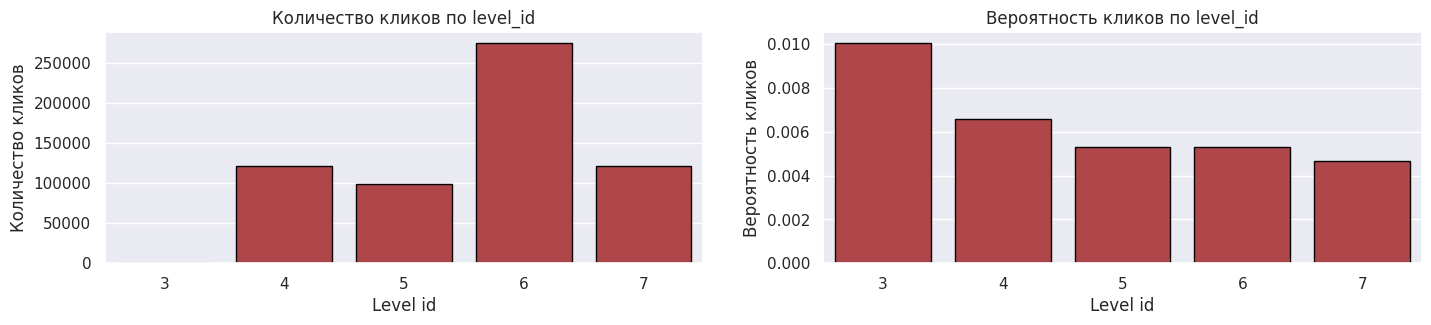

In [73]:
#Группируем данные по дням недели и считаем количество кликов
clicks = df.filter(pl.col('sample') == 1).group_by("level_id").agg([pl.mean("target").alias('mean'),
                                                                             pl.sum("target").alias('sum')])
# Превращаем Polars DataFrame в Pandas DataFrame для удобства использования с Matplotlib
pd_df = clicks.to_pandas().sort_values(by='level_id')
# Строим столбчатую диаграмму
fig, axes = plt.subplots(1, 2, figsize=(17, 3))

sns.barplot(pd_df, x='level_id', y='sum', edgecolor='black', ax=axes[0])
axes[0].set_xlabel('Level id')
axes[0].set_ylabel('Количество кликов')
axes[0].set_title('Количество кликов по level_id');

sns.barplot(pd_df, x='level_id', y='mean', edgecolor='black', ax=axes[1])
axes[1].set_xlabel('Level id')
axes[1].set_ylabel('Вероятность кликов')
axes[1].set_title('Вероятность кликов по level_id');
plt.show();

В зависимости от уровня в дереве микрокатегорий вероятность клика, а также их количество сильно отличается. Не смотря на высокую вероятность клика у 3 уровня, общее количество кликов крайне мало. Самая высокая вероятность и при этом большое количествокликов у 4 категории. Поэтому выделим эти 2 уровня в отдельный бинарный признак.

In [74]:
df = df.with_columns(
    ((pl.col('level_id') == 3) | (pl.col('level_id') == 4 )).alias('is_level_3_4')
)

# Смотрмм как менялась целевая переменная в зависимости от vertical_id

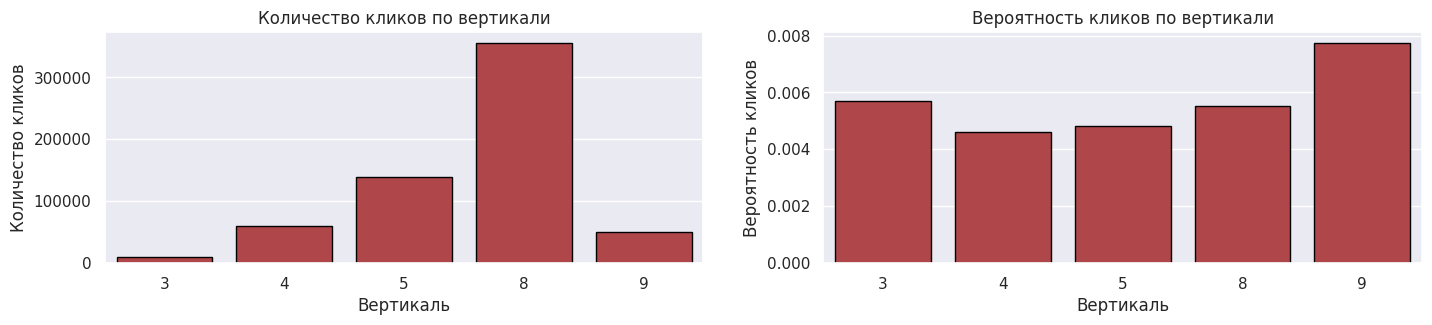

In [75]:
#Группируем данные по дням недели и считаем количество кликов
clicks = df.filter(pl.col('sample') == 1).group_by("vertical_id").agg([pl.mean("target").alias('mean'),
                                                                             pl.sum("target").alias('sum')])
# Превращаем Polars DataFrame в Pandas DataFrame для удобства использования с Matplotlib
pd_df = clicks.to_pandas().sort_values(by='vertical_id')
# Строим столбчатую диаграмму
fig, axes = plt.subplots(1, 2, figsize=(17, 3))

sns.barplot(pd_df, x='vertical_id', y='sum', edgecolor='black', ax=axes[0])
axes[0].set_xlabel('Вертикаль')
axes[0].set_ylabel('Количество кликов')
axes[0].set_title('Количество кликов по вертикали');

sns.barplot(pd_df, x='vertical_id', y='mean', edgecolor='black', ax=axes[1])
axes[1].set_xlabel('Вертикаль')
axes[1].set_ylabel('Вероятность кликов')
axes[1].set_title('Вероятность кликов по вертикали');
plt.show();

В заивисмотси от вертикали также меняется как вероятность так и количество кликов.

In [76]:
df = df.with_columns(
    ((pl.col('vertical_id') == 8) | (pl.col('vertical_id') == 9)).alias('is_vertical_8_9')
)

# Смотрим как менялась целевая переменная в зависимости от показа на главной странице или же нет.

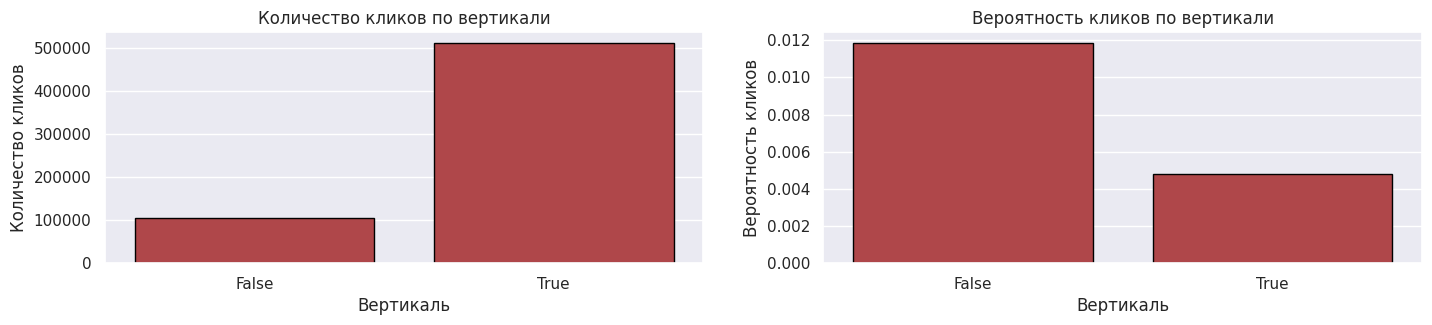

In [77]:
#Группируем данные по дням недели и считаем количество кликов
clicks = df.filter(pl.col('sample') == 1).group_by("is_main").agg([pl.mean("target").alias('mean'),
                                                                             pl.sum("target").alias('sum')])
# Превращаем Polars DataFrame в Pandas DataFrame для удобства использования с Matplotlib
pd_df = clicks.to_pandas().sort_values(by='is_main')
# Строим столбчатую диаграмму
fig, axes = plt.subplots(1, 2, figsize=(17, 3))

sns.barplot(pd_df, x='is_main', y='sum', edgecolor='black', ax=axes[0])
axes[0].set_xlabel('Вертикаль')
axes[0].set_ylabel('Количество кликов')
axes[0].set_title('Количество кликов по вертикали');

sns.barplot(pd_df, x='is_main', y='mean', edgecolor='black', ax=axes[1])
axes[1].set_xlabel('Вертикаль')
axes[1].set_ylabel('Вероятность кликов')
axes[1].set_title('Вероятность кликов по вертикали');
plt.show();

Видим, что  больше показов рекламных кампаний ведется с главной страницы, но вероятность клика выше у тех кампаний, чьи объявления были не на главной странице.

# Отбираем финальные признаки

In [126]:
cat_cols = [
 'categories_id1',
 'categories_id2',
 'categories_id3',
 'categories_id4',
 'categories_id5',
 'categories_id6',
 'categories_id7',
 'categories_id8',
 'categories_id9',
 'categories_id11',
 'platform_id_1',
 'platform_id_2',
 'platform_id_3',
 'platform_id_4',
 'banner_code_1',
 'banner_code_2',
 'banner_code_3',
 'banner_code_4',
 'banner_code_5',
 'banner_code_6',
 'banner_code_7',
 'banner_code_8',
 'week_1',
 'week_2',
 'week_3',
 'week_4',
 'is_level_3_4',
 'is_vertical_8_9',
 'is_main',
 'is_saturday',
 'is_fri_or_sund',
 'is_click_category',
 'is_click_banner_code',
 'is_first_show_adv_campaign_for_user'   
]
num_cols = [
 'ctr_user_campaign',
 'cumsum_user_campaign_shows',
 'cumsum_user_campaign_clicks',
 'cumsum_user_logcat_shows',
 'ctr_user_logcat',
 'shift_ctr_user_adv_campaign_week',
 'shift_ctr_user_logcat_week',
 'ctr_adv_campaign',
 'ctr_banner',
 'ctr_banner_us',
 'ctr_banner_us_week',
 'ctr_location',
 'duration_days',
 'days_since_campaign_start',
 'ctr_user',
 'ctr_user_week',
 'cumsum_adv_campaign_clicks',
 'budget_balances',
 'ctr_creative_banner',
 'ctr_creative_banner_w',
 'ctr_us_cam_main',
 'total_unique_campaigns_before_today',
 'total_unique_banners_before_today',
 'total_unique_creative_before_today'
]

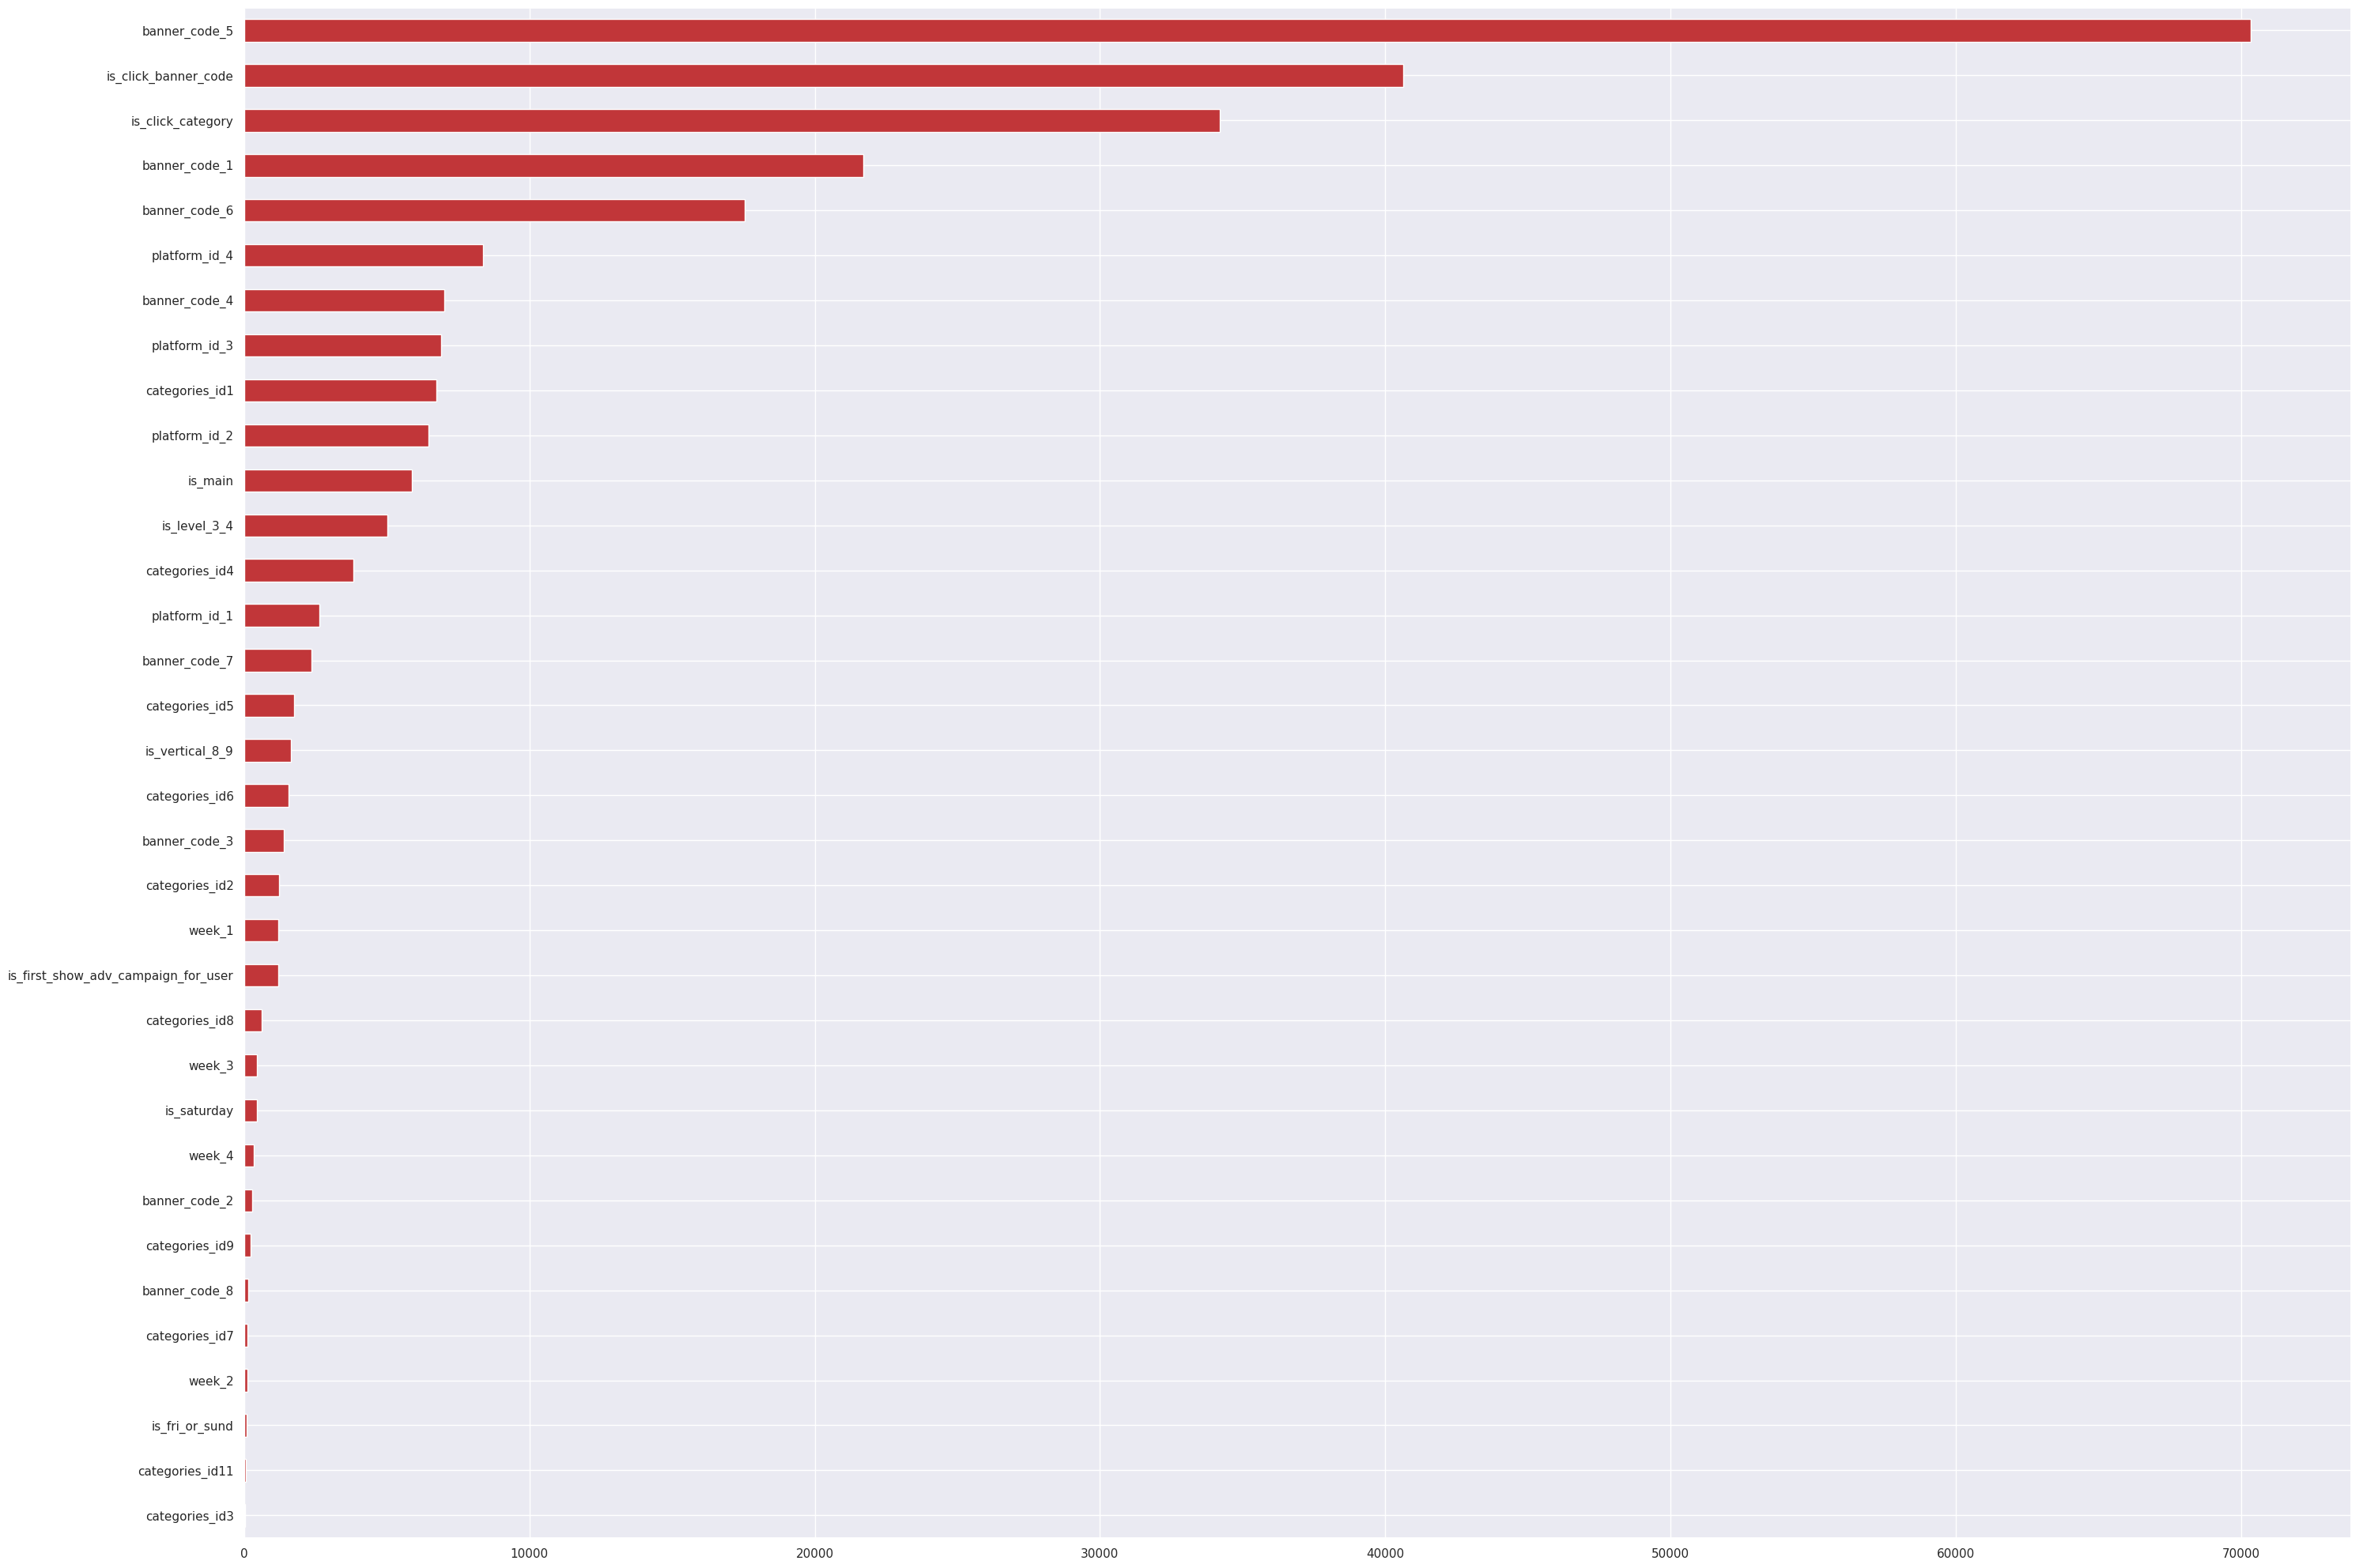

In [130]:
y = df.filter(pl.col('sample') == 1)['target']

imp_cat = pd.Series(chi2(df.filter(pl.col('sample') == 1)[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(30, 20))
imp_cat.plot(kind = 'barh');

plt.tight_layout();

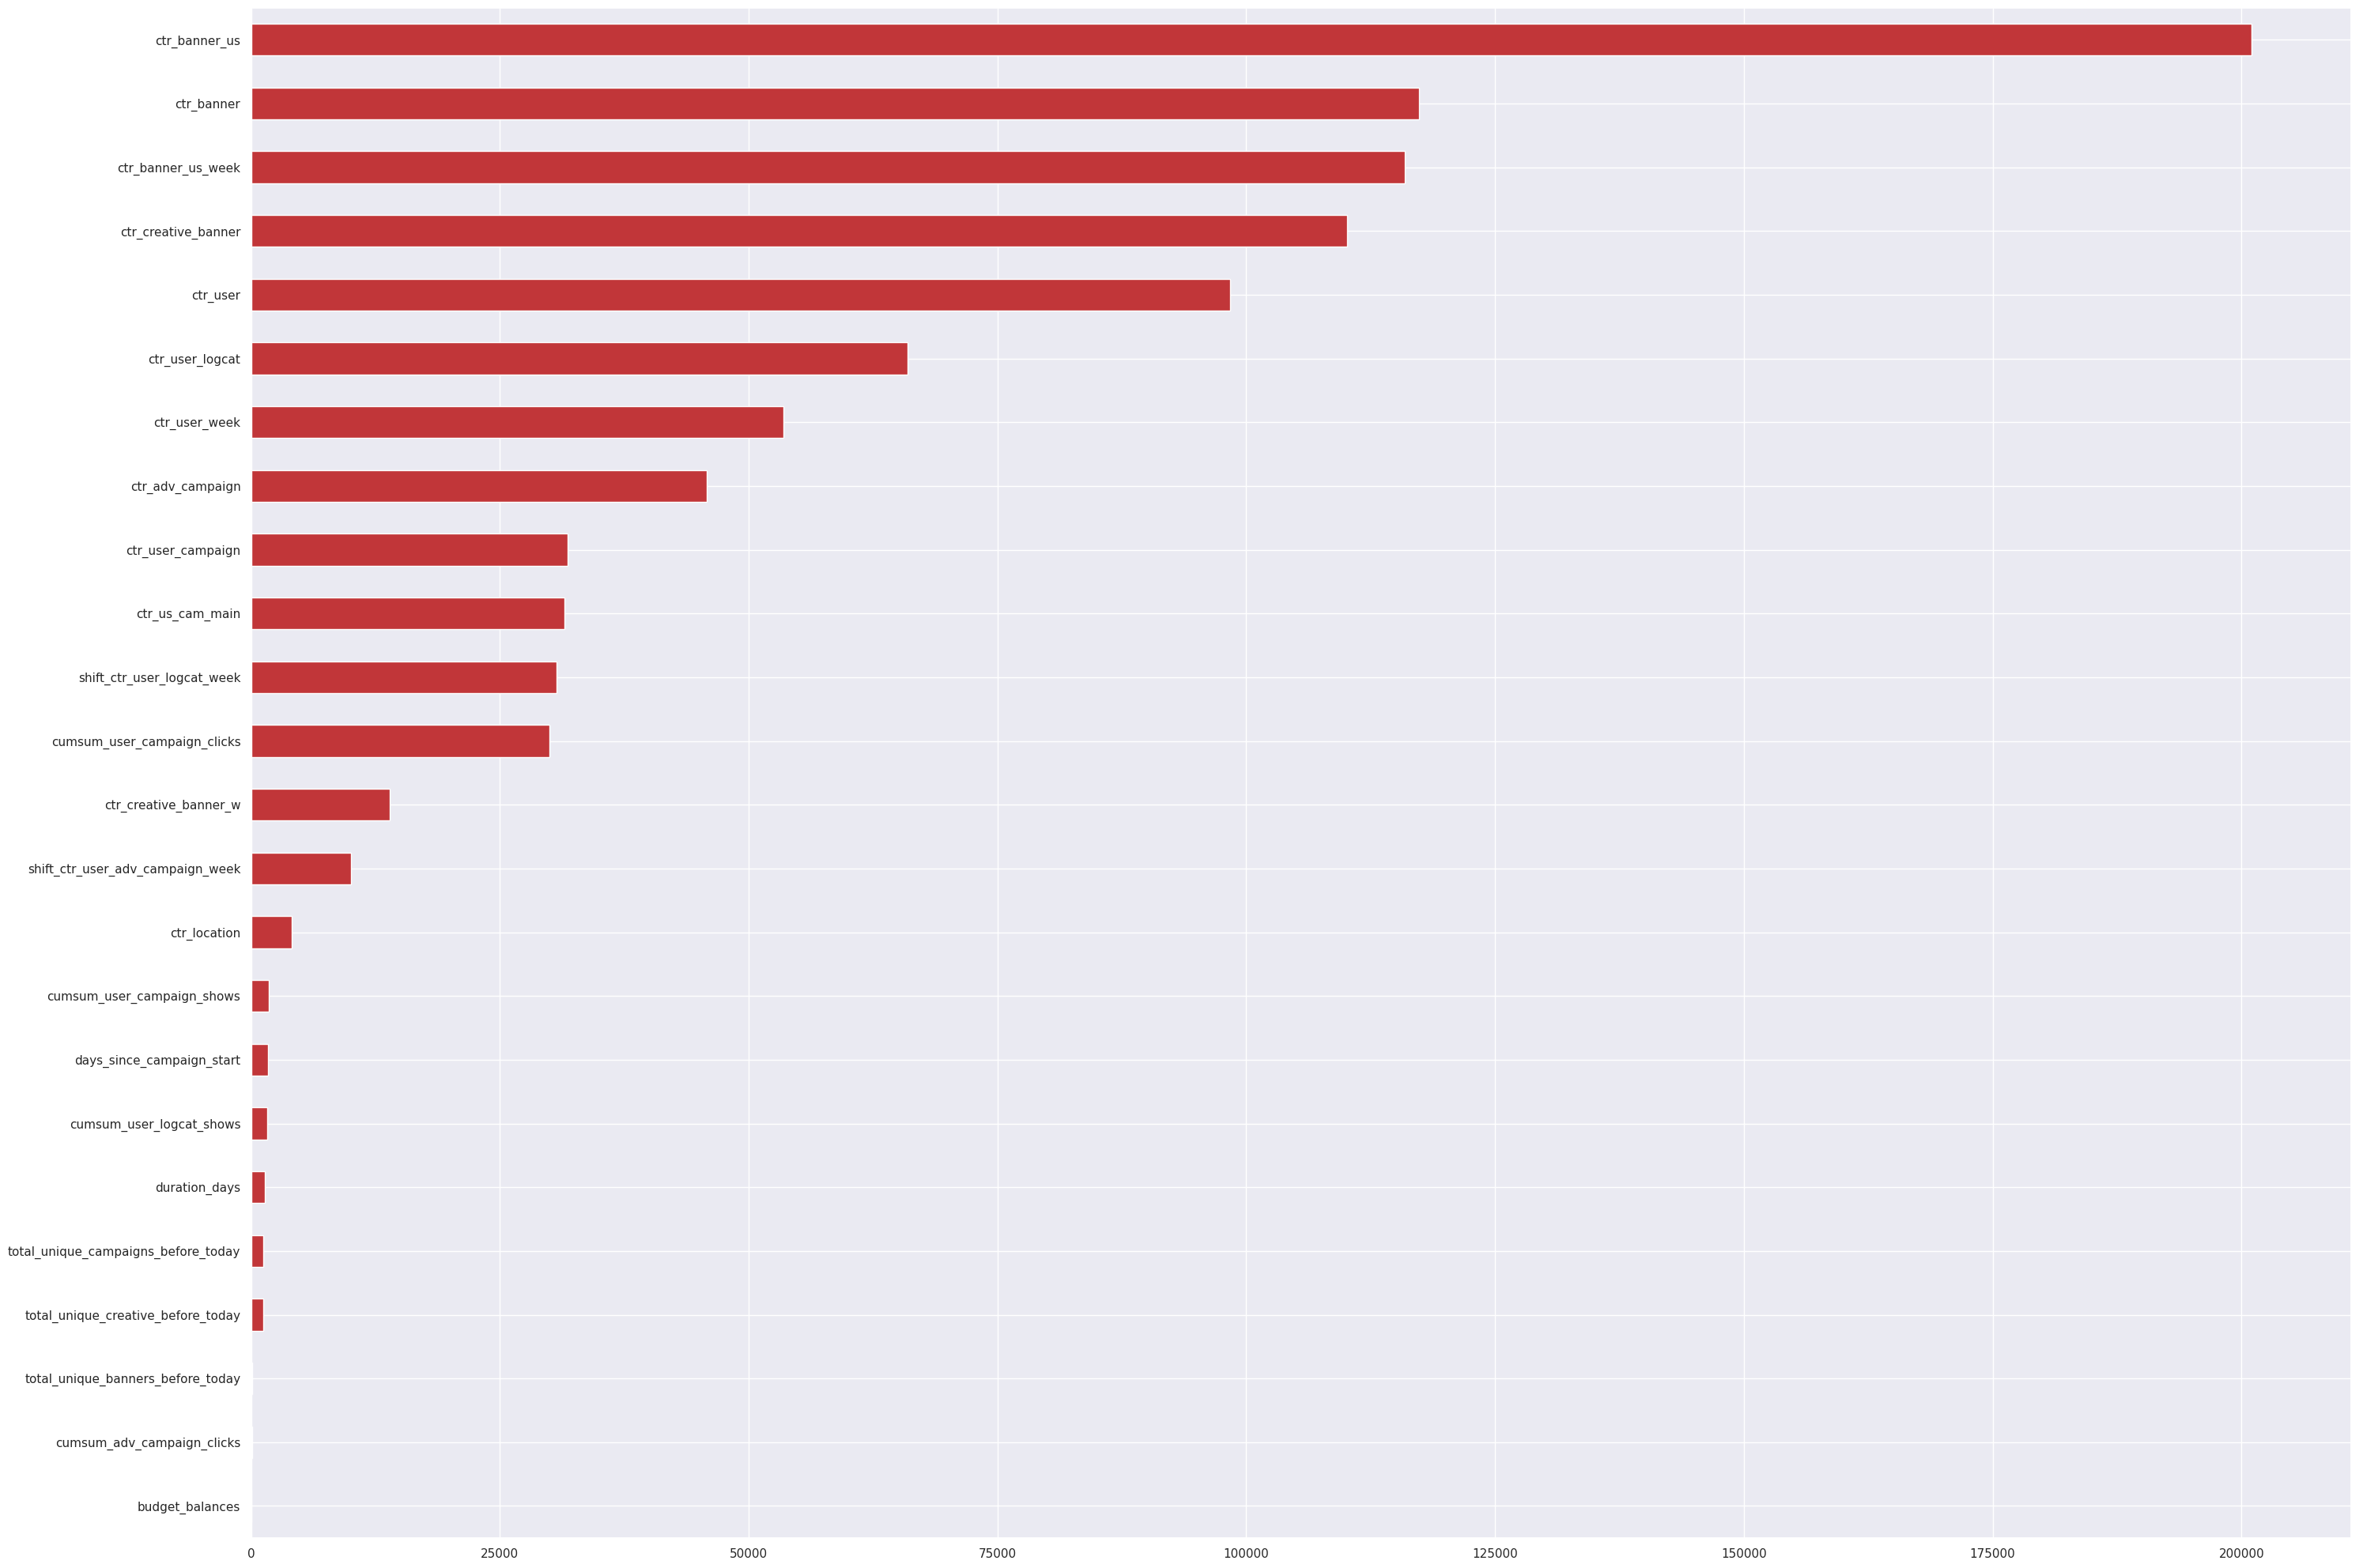

In [132]:
# визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(df.filter(pl.col('sample') == 1)[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(30, 20))
imp_num.plot(kind = 'barh')

plt.tight_layout();

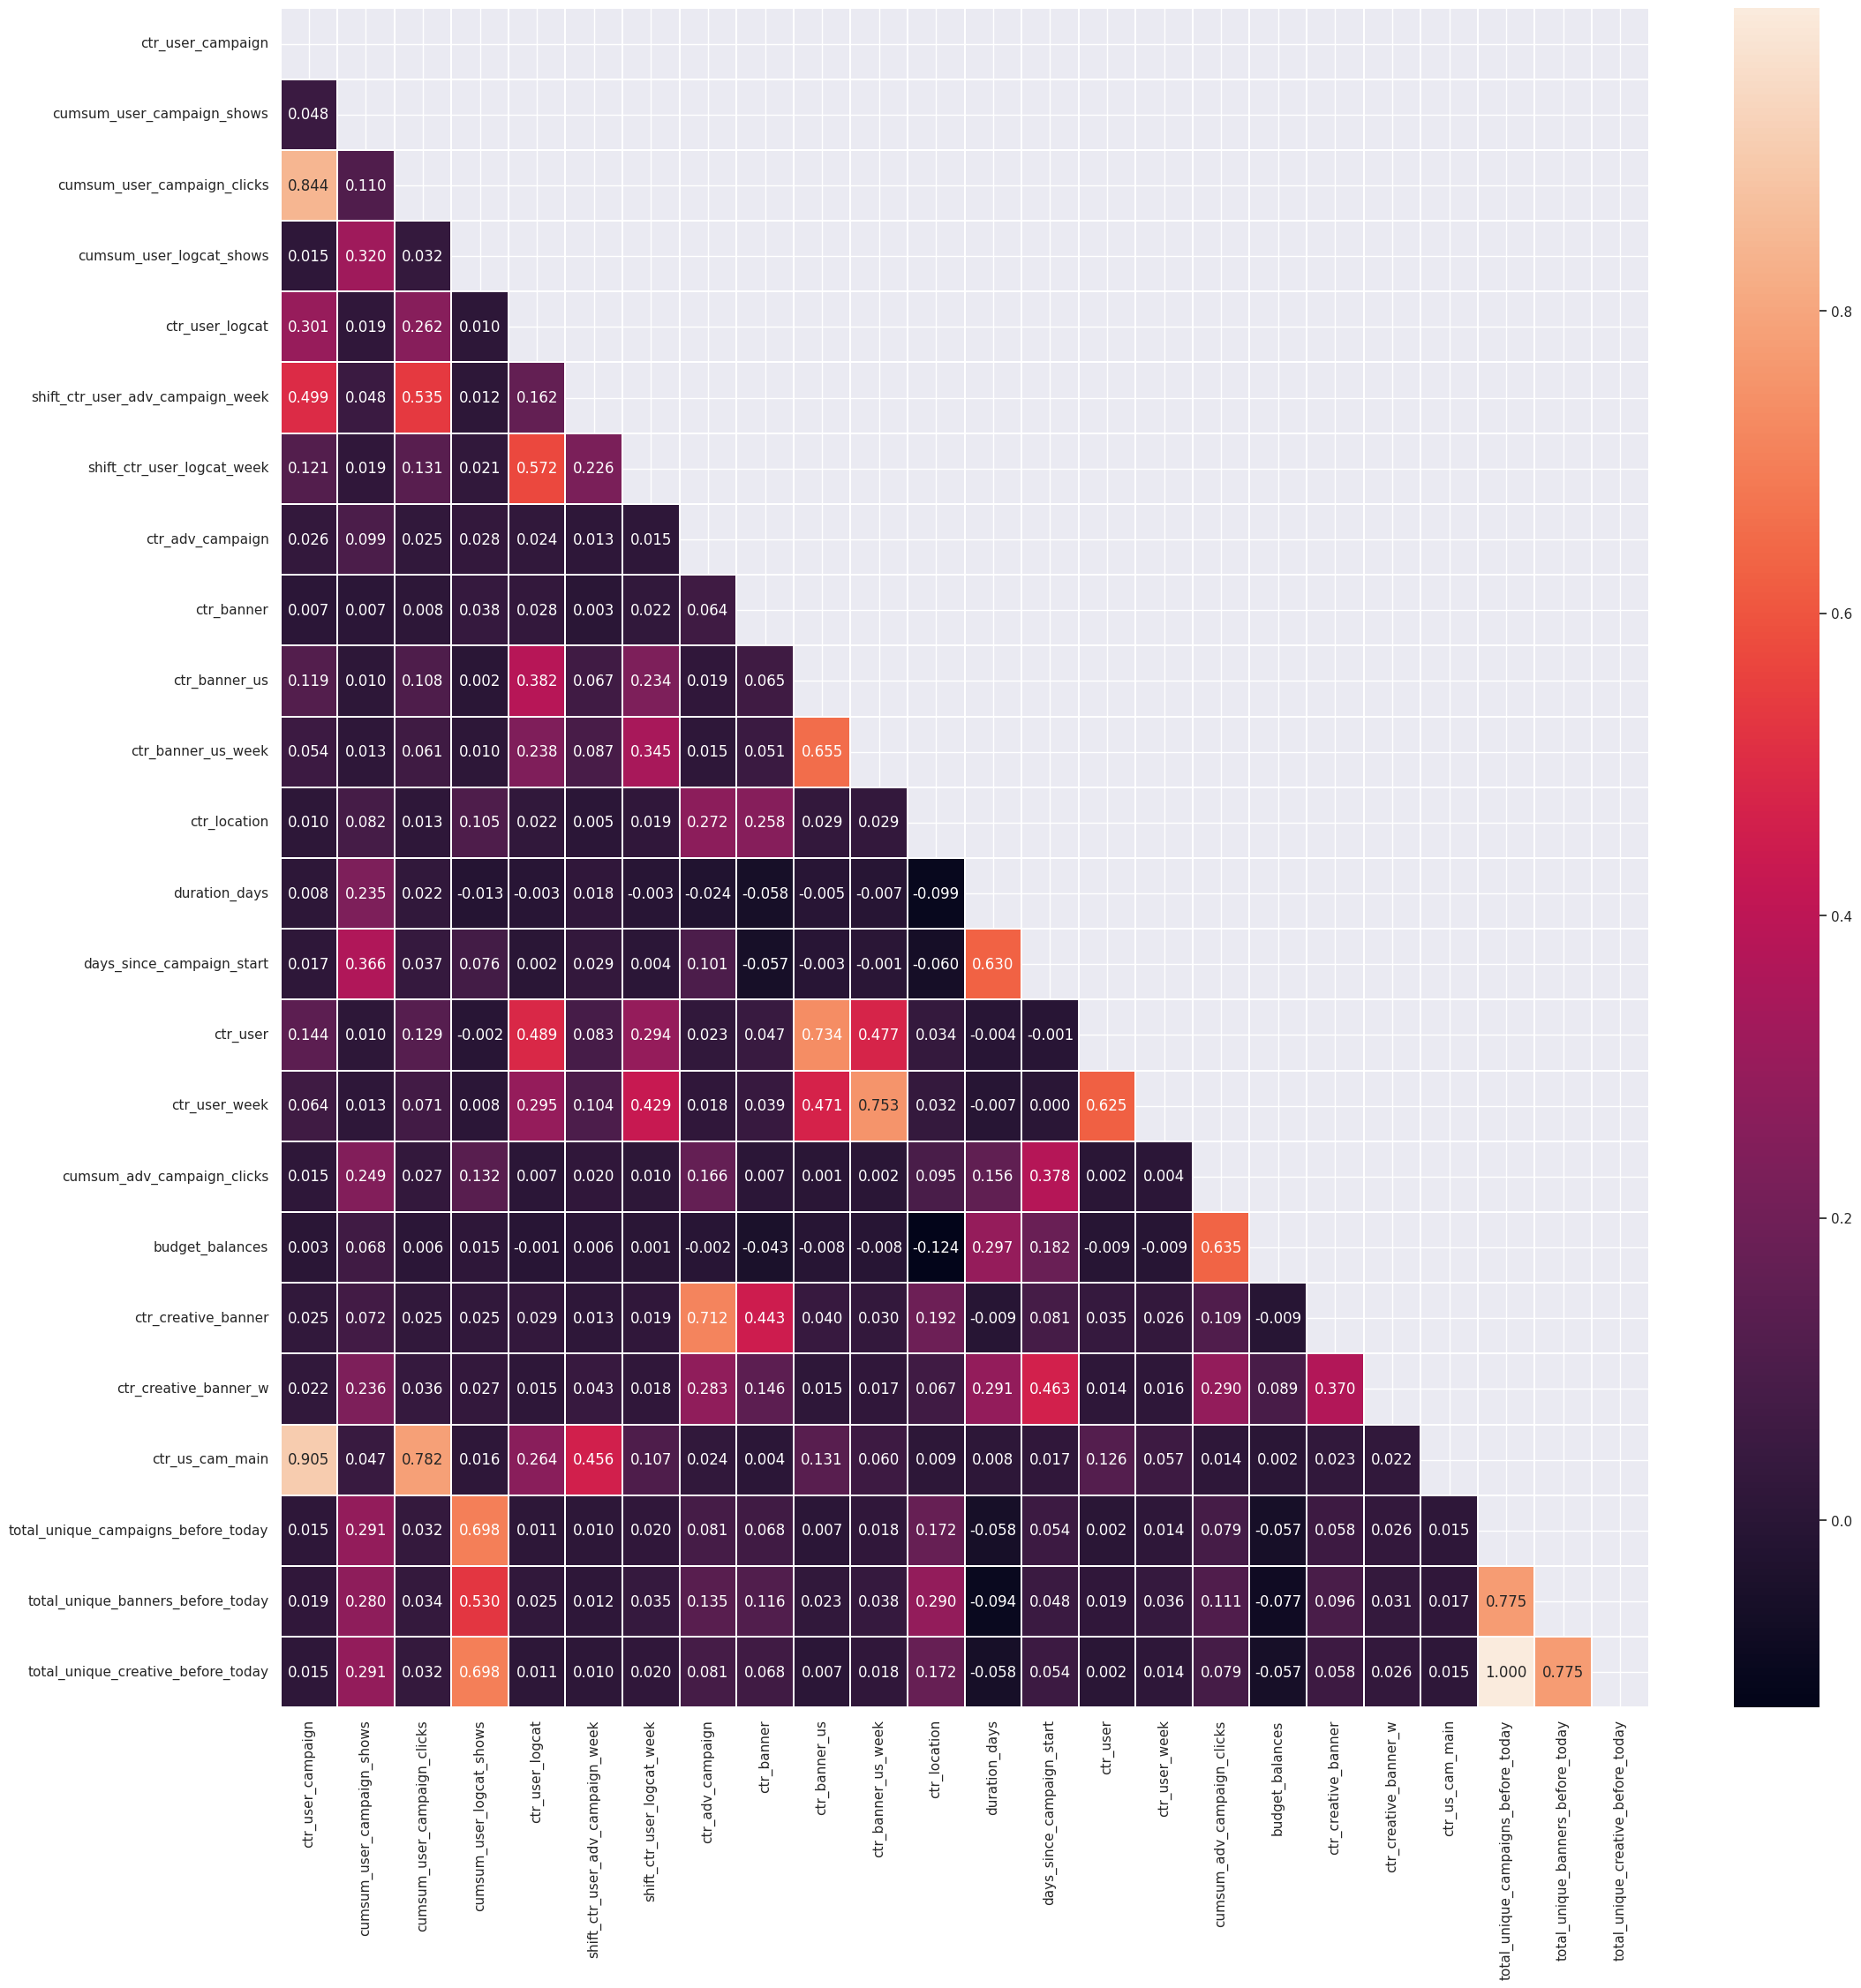

In [129]:
fig_, ax_ = plt.subplots(figsize=(25, 25))
corr = df.filter(pl.col('sample') == 1)[num_cols].to_pandas().corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, 
            annot=True, 
            linewidths=0.1, 
            ax=ax_, 
            mask=mask, 
            fmt='.3f')
plt.show()

# Сохраним полученый результат

In [133]:
# # Сохраняем DataFrame в файл Parquet
df.write_parquet("df_final.parquet")

Оценив важность признаков и их корреляцию, составляем итоговый набор признаков для предсказания.

In [82]:
final_cols = [
'total_unique_banners_before_today',
'total_unique_campaigns_before_today',
 'is_vertical_8_9',
 'is_level_3_4',
 'shift_ctr_user_logcat_week',
 'budget_balances',
 'is_click_banner_code',
 'ctr_creative_banner',
'ctr_creative_banner_w',
 'is_main',
 'ctr_user_campaign',
 'cumsum_user_logcat_shows',
 'ctr_user_logcat',
 'is_first_show_adv_campaign_for_user',
 'shift_ctr_user_adv_campaign_week',
 'is_saturday',
 'is_fri_or_sund',
 'ctr_adv_campaign',
 'ctr_banner',
 'days_since_campaign_start',
 'ctr_location',
 'ctr_user',
 'is_click_category',
 'categories_id1',
 'categories_id2',
 'categories_id3',
 'categories_id4',
 'categories_id5',
 'categories_id6',
 'categories_id7',
 'categories_id8',
 'categories_id9',
 'categories_id11',
 'platform_id_1',
 'platform_id_2',
 'platform_id_3',
 'platform_id_4',
 'week_1',
 'week_2',
 'week_3',
 'week_4',
 'ctr_banner_us',
 'ctr_user_week',
'ctr_banner_us_week']

# Приступаем к обучению и проверке модели

Проверяем разменость 

In [78]:
df.shape

(116724322, 78)

# Разделяем обратно на тренировочный и тестовый

In [145]:
# Фильтрация и удаление колонок
train_data = df.filter(pl.col("sample") == 1).drop("sample")

test_data = df.filter(pl.col("sample") == 0).drop("sample")

train_data = df.sort(by='event_date')

# Обучаем модель, каждый раз добавляя к обучению новую неделю и проверяя на последующей.

In [83]:
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

res = []
for w in range(36, 38):
    # Фильтрация данных
    X_train = train_data.filter((pl.col('week') <= w))
    X_test = train_data.filter(pl.col('week') == w + 1)
    y_train = X_train['target'].to_pandas()
    y_test = X_test['target'].to_pandas()
    X_train = X_train[final_cols].to_pandas()
    X_test = X_test[final_cols].to_pandas()

    # Автоматическое вычисление весов для классов
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weights = {0: class_weights[0], 1: class_weights[1]}
    sample_weights = np.array([weights[label] for label in y_train])

    # Создание Dataset с весами
    lgb_train = lgb.Dataset(X_train, label=y_train, weight=sample_weights)

    # Настройки параметров модели
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'num_leaves': 31,
        'learning_rate': 0.09,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.9,
        'bagging_freq': 10,
        'verbose': -1  # Отключение вывода
    }

    # Обучение модели
    num_round = 100
    model = lgb.train(params, lgb_train, num_round)

    # Прогнозирование вероятностей на тестовых данных
    y_pred_prob = model.predict(X_test)

    # Оценка точности модели
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {roc_auc:.5f}")
    
print(np.mean(res))

[LightGBM] [Info] Number of positive: 92697, number of negative: 19102054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.264801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2423
[LightGBM] [Info] Number of data points in the train set: 19194751, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004829 -> initscore=-5.328215
[LightGBM] [Info] Start training from score -5.328215
AUC-ROC: 0.67325
[LightGBM] [Info] Number of positive: 314817, number of negative: 60745671
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.822232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 61060488, number of used f

# Посмотрим на важность признаков для модели

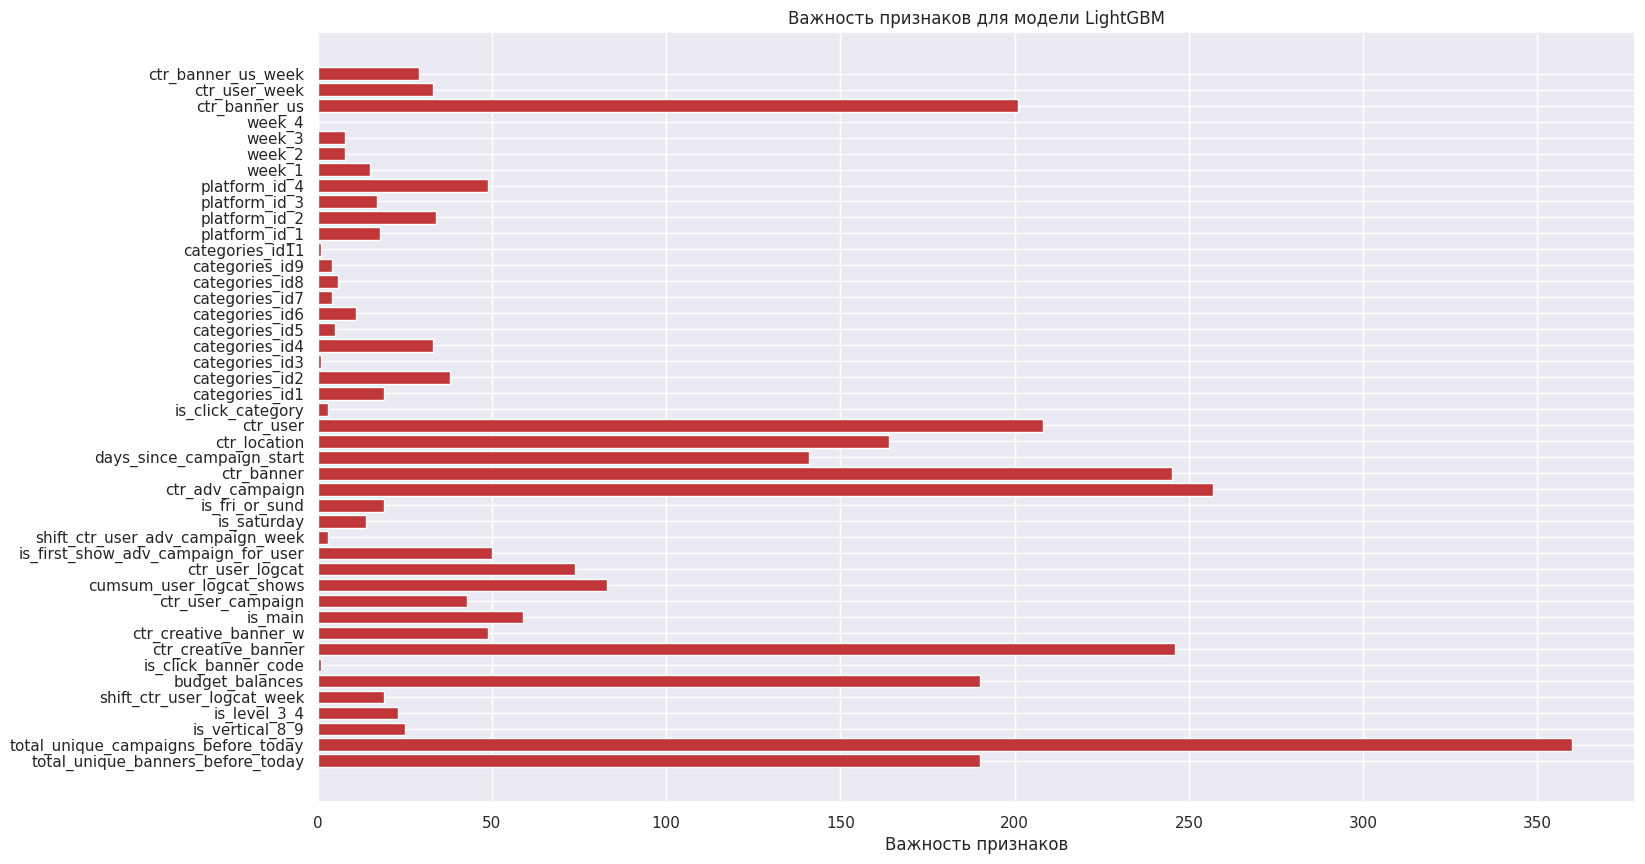

In [84]:
# Получение важности признаков
feature_importance = model.feature_importance()

feature_names = model.feature_name()  

# Визуализация важности признаков
plt.figure(figsize=(17, 10))
plt.barh(feature_names, feature_importance)
plt.xlabel("Важность признаков")
plt.title("Важность признаков для модели LightGBM")
plt.show()

# Предсказываем на тестовой выборке и сохраняем  в файл сабмишн

In [146]:
test_data = test_data[final_cols].to_pandas()

In [147]:
# Прогноз вероятности клика на тестовых данных
y_pred_prob = model.predict(test_data)

# Выводим вероятности
print("Вероятности клика:", y_pred_prob)


Вероятности клика: [0.63916408 0.49038867 0.61648391 ... 0.56127459 0.71648311 0.52553003]


In [148]:
y_pred_prob.min()

0.07497166717778722

In [149]:
y_pred_prob.max()

0.9881979728185326

In [ ]:
sample_submission = pl.read_csv('https://storage.yandexcloud.net/ds-ods/files/files/d901afa5/sample_submission.csv') 
sample_submission = sample_submission.with_columns(pl.lit(y_pred_prob).alias("predict"))
sample_submission.write_csv('sample_submission_123.csv')

На финальном трейне получился результат = 0,6086696219380149

# Можно попробовать объединить модели для предсказания

In [99]:
X_train = train_data.filter((pl.col('week') <= 37))
X_test = train_data.filter(pl.col('week') == 38) 
y_train = X_train['target']  # Целевая переменная для обучающей выборки
y_test = X_test['target']

X_train = X_train[final_cols].to_pandas()
X_test = X_test[final_cols].to_pandas()
y_train = y_train.to_pandas()
y_test = y_test.to_pandas()

In [100]:
# Определение моделей
model1 = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    metric='auc',
    num_leaves=31,
    learning_rate=0.09,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5,
    random_state=42
)

model2 = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    max_depth=6,
    learning_rate=0.09,
    n_estimators=100,
    random_state=42
)

# Объединение моделей в ансамбль
ensemble_model = VotingClassifier(estimators=[
    ('lgb', model1),
    ('xgb', model2)],
    voting='soft')  # Используйте 'soft' для предсказания вероятностей

# Обучение ансамбля
ensemble_model.fit(X_train, y_train)

# Прогнозирование вероятностей
y_pred_prob = ensemble_model.predict_proba(X_test)[:, 0]

# Оценка AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC-ROC: {roc_auc:.5f}")
# Оценка AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_prob)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 314817, number of negative: 60745671
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.372618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[

In [ ]:
y_pred_prob = ensemble_model.predict_proba(test_data)[:, 0]
sample_submission = pl.read_csv('https://storage.yandexcloud.net/ds-ods/files/files/d901afa5/sample_submission.csv') 
sample_submission = sample_submission.with_columns(pl.lit(y_pred_prob).alias("predict"))
sample_submission.write_csv('sample_submission_126.csv')

ROC AUC сильно не изменился.

Результаты на финальном сете, дали результат = 0,6084457020363744

## Итоги

По завершению соревнования, на публичном лидерборде получился результат = 0,6086696219
А на приватном 0,6089422102. Результаты сопоставимы, а значит модель устойчива к разным данных.
По итогам соревнования удалось войти в 30-ку лидерборда.

LightGBM показал результат значительно выше, чем CatBoost из базового решения. 
Объединение нескольких моделей не дала желаемого улучшения предсказательной способности.
